In [1]:
START_NUM=450;
END_NUM=600;

### Goal: Feature Importance.

The idea is to use the permutation importance to the neural network.
1. Fit the model with all the features of interest.
2. For each column:
  - Randomly permute the values in the column
  - Compute the drop in training RMSE
  - The more important the feature is, theoretically the more is the performance drop.

In [2]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.metrics import mean_squared_error;

2.6.0


In [3]:
pd.set_option('display.max_columns', 300);
pd.set_option('display.max_rows', 300);
tf.keras.backend.set_floatx('float64');

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [5]:
MONTHS = 60;
SPLIT = 48; # 2015-2018: training, 2019: testing.
# BATCH_SIZE = 19; # used in NN_v1
BATCH_SIZE = 24;
WINDOW_SIZE = 1;

TEST_LENGTH = MONTHS - SPLIT;

### Data preparation

In [6]:
multi_data = pd.read_csv('../data/full_dataset_unscaled.csv', index_col = 0);
zip_ids = multi_data.index.unique();

multi_data.drop(["City", "State", "Metro", "CountyName", "year", "month", "datetime"],\
                 axis = 1, inplace = True);

multi_data.head()

zri  percent_white  percent_black  percent_asian  percent_hispanic  \
zip                                                                          
1013  946.0       0.714892       0.023829       0.013748          0.230129   
1013  950.0       0.715367       0.024195       0.014023          0.229024   
1013  958.0       0.715842       0.024561       0.014299          0.227919   
1013  958.0       0.716318       0.024927       0.014574          0.226813   
1013  955.0       0.716793       0.025294       0.014850          0.225708   

      percent_native_am  percent_other_race  percent_0_17  percent_18_39  \
zip                                                                        
1013           0.000113            0.004539      0.224062       0.314378   
1013           0.000226            0.004587      0.223443       0.316319   
1013           0.000339            0.004634      0.222823       0.318260   
1013           0.000452            0.004682      0.222204       0.320201   
1013           0.000565            0.004730      0.221584       0.322142   

      percent_40_64  percent_65+  percent_rental_units_vacant  \
zip                                                             
1013       0.316595     0.144965                     0.057735   
1013       0.315346     0.144892                     0.057503   
1013       0.314097     0.144820                     0.057270   
1013       0.312847     0.144748                     0.057038   
1013       0.311598     0.144675                     0.056805   

      percent_rental_units_occupied  percent_graduate_deg  percent_bachelors  \
zip                                                                            
1013                       0.942265              0.029555           0.062456   
1013                       0.942497              0.029598           0.062682   
1013                       0.942730              0.029641           0.062908   
1013                       0.942962              0.029684           0.063134   
1013                       0.943195              0.029727           0.063359   

      percent_associates  percent_highschool  percent_less_highschool  \
zip                                                                     
1013            0.257328            0.383459                 0.218492   
1013            0.255708            0.385186                 0.217890   
1013            0.254088            0.386912                 0.217289   
1013            0.252468            0.388639                 0.216687   
1013            0.250848            0.390365                 0.216086   

      percent_commute_public_transport  percent_commute_less_30  \
zip                                                               
1013                          0.022609                 0.731245   
1013                          0.023198                 0.733361   
1013                          0.023787                 0.735477   
1013                          0.024375                 0.737593   
1013                          0.024964                 0.739709   

      percent_buildings_less_10_units  percent_buildings_10_19_units  \
zip                                                                    
1013                         0.883422                       0.030202   
1013                         0.883598                       0.030477   
1013                         0.883775                       0.030752   
1013                         0.883952                       0.031027   
1013                         0.884128                       0.031302   

      percent_buildings_20_49_units  percent_buildings_50+_units  \
zip                                                                
1013                       0.036863                     0.049514   
1013                       0.036368                     0.049557   
1013                       0.035873                     0.049601   
1013                       0.035378                     0.049644   
1013            

In [7]:
FEATURES = multi_data.shape[1] - 1;

feature_name = list(multi_data.columns);

### Utility functions

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series); #(43,)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True);
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)); #(13,43)
    dataset = dataset.shuffle(shuffle_buffer)\
                     .map(lambda window: (window[:-1, 1:], window[-1][0]));
    dataset = dataset.batch(batch_size).prefetch(1);
    return dataset;

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Frame")
    plt.ylabel("ZRI")
    plt.grid(True)

### Neural network center

In [10]:
def NN_model(dataset, termination=0, test = None):
    tf.keras.backend.clear_session();
    # dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    class myCallbacks(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            mse = logs.get("mse");
            if(mse < termination):
                print("\nGot an mse at {:.4f} in epoch {} and stopped training\n".format(mse, epoch));
                self.model.stop_training = True;
            
    callback = myCallbacks();
    
    model = tf.keras.models.Sequential([
#         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                           input_shape=[None]),
#       tf.keras.layers.Conv1D(filters=32, kernel_size=3,
#                           strides=1, padding="causal",
#                           activation="relu",
#                           input_shape=[None, WINDOW_SIZE, FEATURES+1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, input_shape = [None, WINDOW_SIZE, FEATURES])),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        # tf.keras.layers.SimpleRNN(8, return_sequences=True),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
        tf.keras.layers.Dense(8, activation="relu"),
    #   tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.Lambda(lambda x: x * 2.0)
    ]);
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae", "mse"])

    model.build((None,WINDOW_SIZE,FEATURES))
    # model.summary()

    if not test: history = model.fit(dataset, epochs=500, callbacks = [callback], verbose = 0);
    else: history = model.fit(dataset, epochs=500, validation_data=test,\
                              callbacks=[callback], verbose = 0);
    return model;

In [11]:
def NN_forecast(model, series_transformed):
    forecast = []
    results = []
    for time in range(MONTHS - WINDOW_SIZE):
        forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, 1:]))

    results = [float(x[-1][0]) for x in forecast];
    actual = list(series_transformed[WINDOW_SIZE:, 0]);
    
    return results, actual;

In [12]:
@tf.autograph.experimental.do_not_convert
def NN_test(ZONE, termination=0, plot=False):
    '''
    Input: ZONE
    Output: the RMSE of a NN model on the predicted train, partially predicted test, and complete predicted test.
    '''
    # Collection of data
    series_frame = multi_data[multi_data.index == ZONE];
    # series_frame.sort_values("datetime", ascending = True, inplace = True);
    
    # Standardization
    scaler = MinMaxScaler();
    series_transformed = scaler.fit_transform(series_frame);
    
    # Train test split
    series_train = series_transformed[:SPLIT];
    series_test = series_transformed[SPLIT-WINDOW_SIZE:];
    
    # Window the training set to make input of the NN
    dataset_train = windowed_dataset(series_train, WINDOW_SIZE, BATCH_SIZE, 60);
    # dataset_test = windowed_dataset(series_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
#     for x, y in dataset_train:
#         print(np.array(x).shape, np.array(y).shape);
    
    model = NN_model(dataset_train, termination);
    
    time_train = list(range(SPLIT));
    time_test = list(range(SPLIT, MONTHS));
    
    # Forecasting
    results, actual = NN_forecast(model, series_transformed);
    
    # Compute MSE
    MSE_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * scaler.data_range_[0];
    MSE_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * scaler.data_range_[0];
    
    if plot: # If the plot option is selected, plot the graph.
        time_actual = range(WINDOW_SIZE, MONTHS);
        plt.figure(figsize=(10, 6))
        plot_series(time_actual, np.array(actual)*scaler.data_range_[0]+scaler.data_min_[0]);
        plot_series(time_actual, np.array(results)*scaler.data_range_[0]+scaler.data_min_[0]);
        plt.show();

    return MSE_train, MSE_test, model, scaler, series_transformed;

### The script


Got an mse at 0.0024 in epoch 65 and stopped training



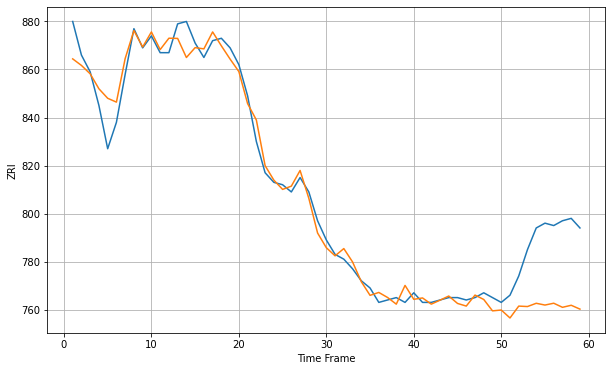

Wall time: 8.94 s
17701 5.7240272328748345 25.50145495381736


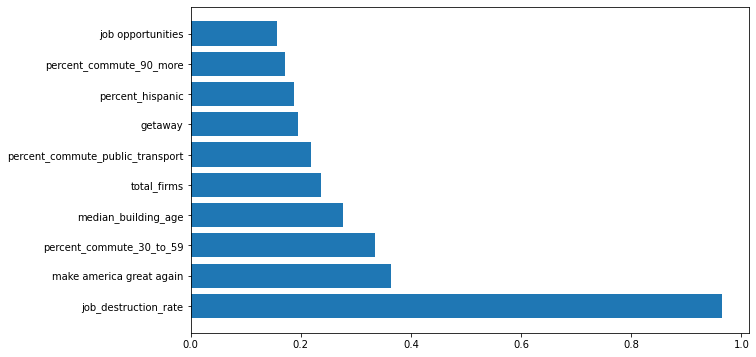


Got an mse at 0.0024 in epoch 27 and stopped training



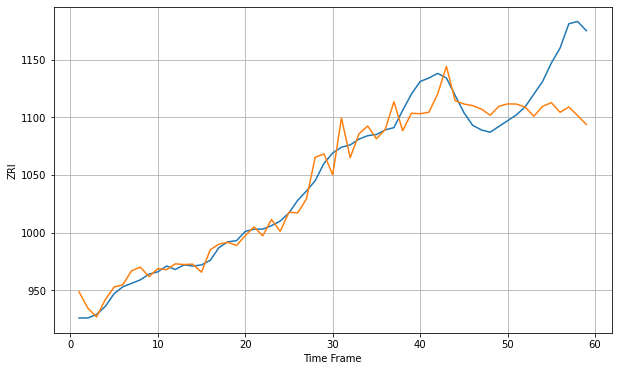

Wall time: 8.83 s
18018 12.201734902367992 45.09185400124298


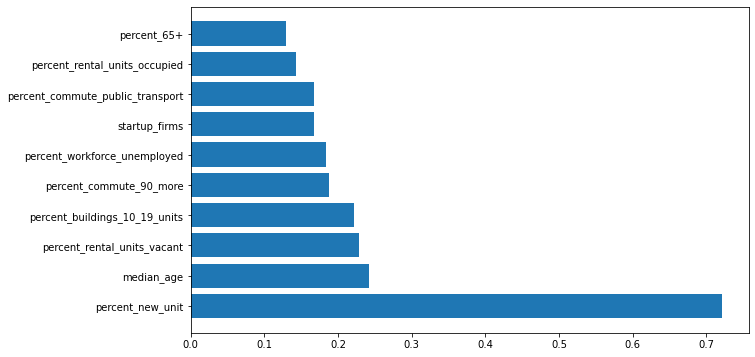


Got an mse at 0.0025 in epoch 40 and stopped training



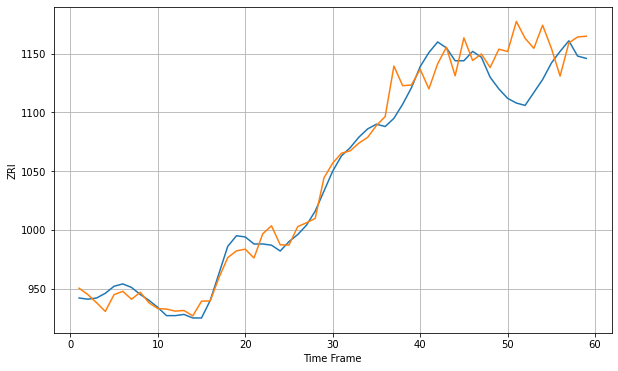

Wall time: 9.12 s
18042 11.565873143129478 36.14044418289355


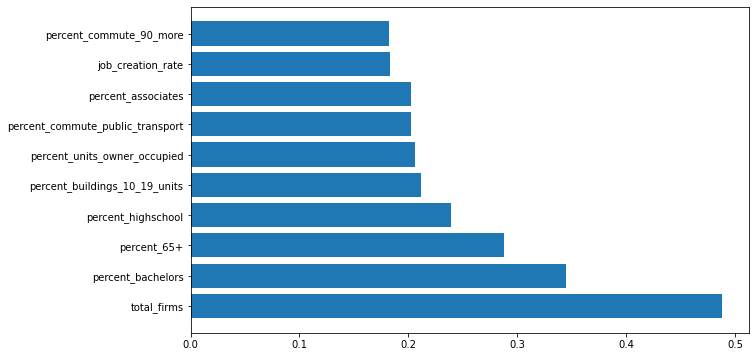


Got an mse at 0.0024 in epoch 29 and stopped training



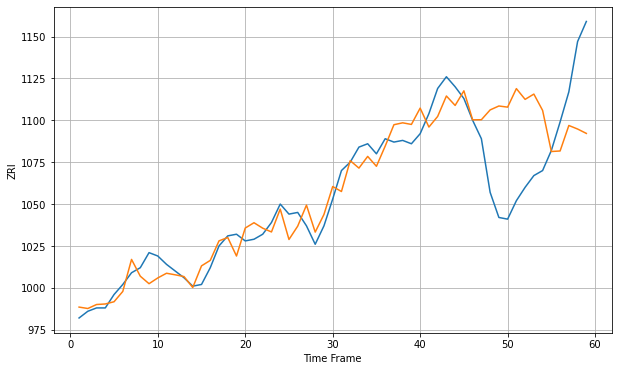

Wall time: 8.81 s
18102 8.805452140978241 50.08485222465748


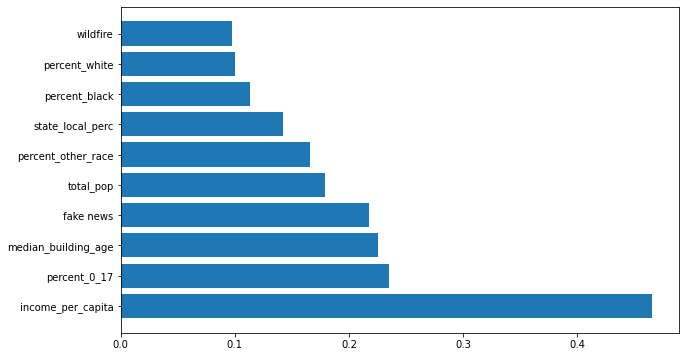


Got an mse at 0.0025 in epoch 157 and stopped training



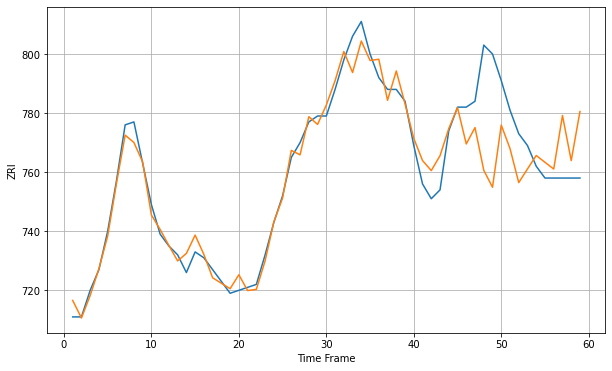

Wall time: 12.7 s
18232 4.8923542918371785 21.606087634217864


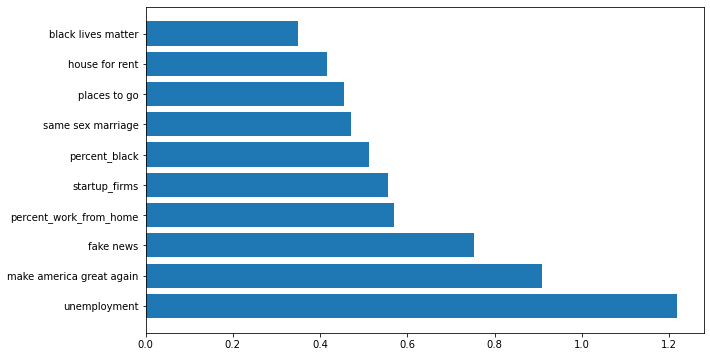


Got an mse at 0.0025 in epoch 53 and stopped training



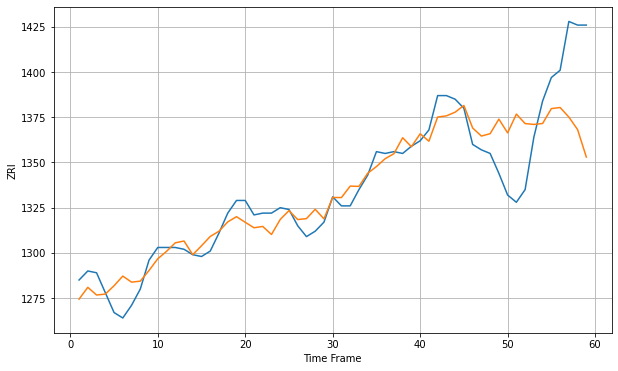

Wall time: 8.94 s
18951 8.124452382071073 39.05145230046039


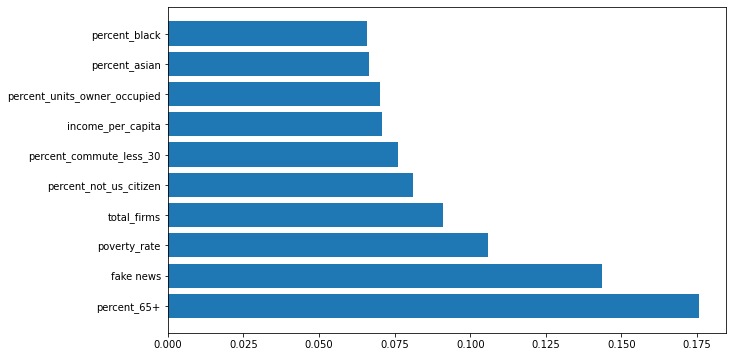


Got an mse at 0.0025 in epoch 39 and stopped training



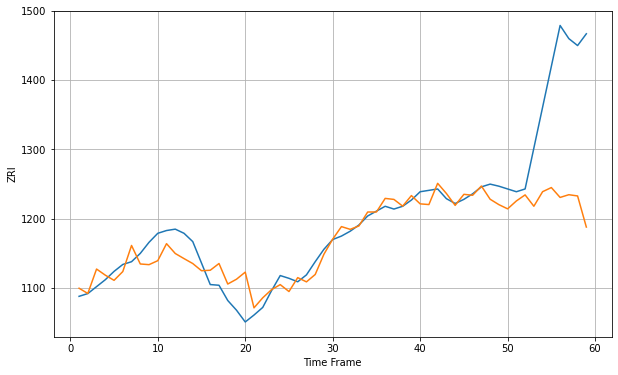

Wall time: 9.16 s
19007 20.917046958869236 156.02738862713616


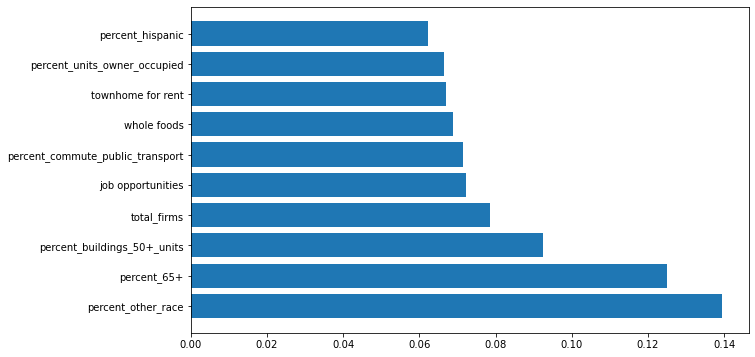


Got an mse at 0.0025 in epoch 166 and stopped training



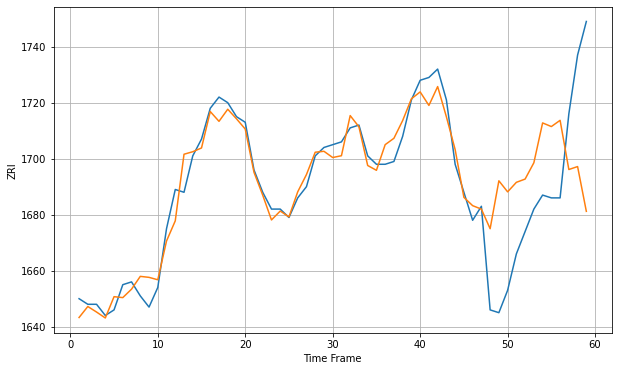

Wall time: 12.8 s
19103 5.117826574371119 34.43542131589807


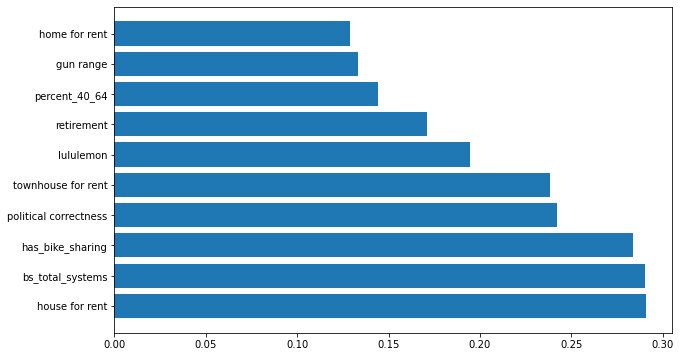


Got an mse at 0.0025 in epoch 107 and stopped training



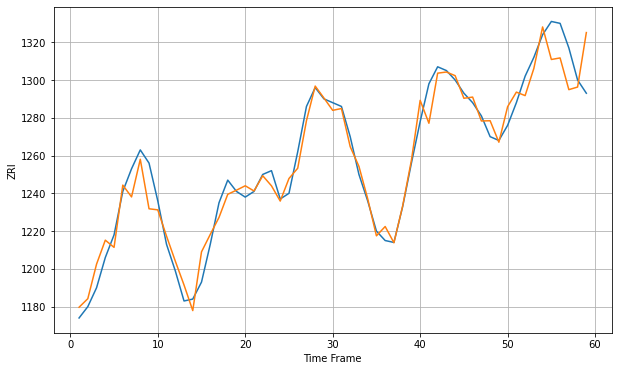

Wall time: 11.7 s
19104 7.698050989275175 14.809283993231029


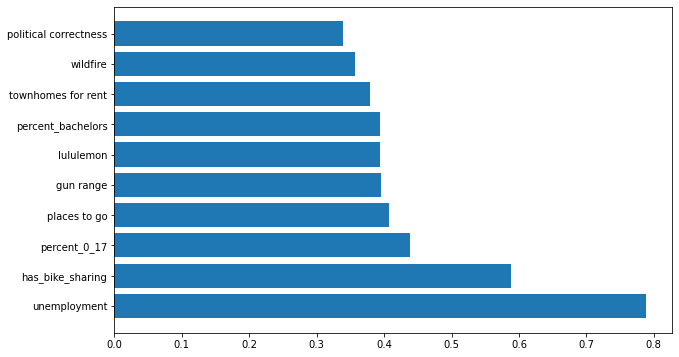


Got an mse at 0.0023 in epoch 13 and stopped training



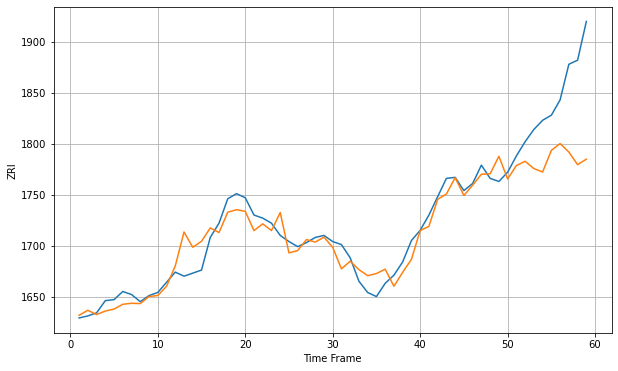

Wall time: 8.27 s
19106 13.348078954598394 60.83389659596778


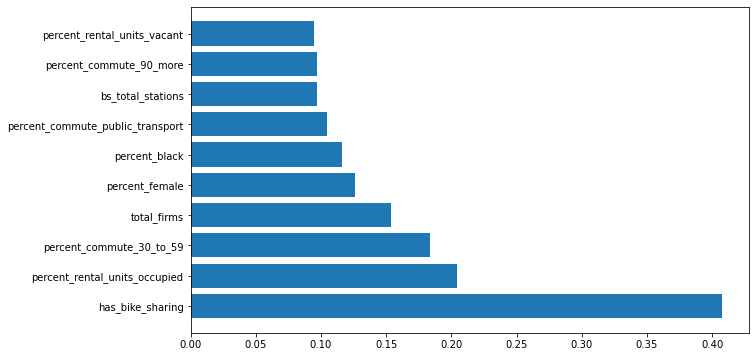


Got an mse at 0.0024 in epoch 88 and stopped training



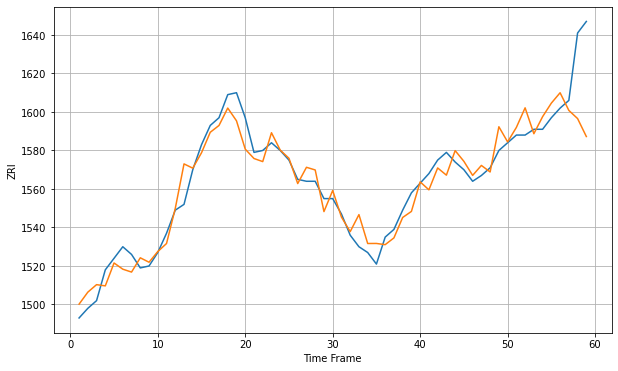

Wall time: 10.1 s
19107 7.541798775648418 22.57433162662177


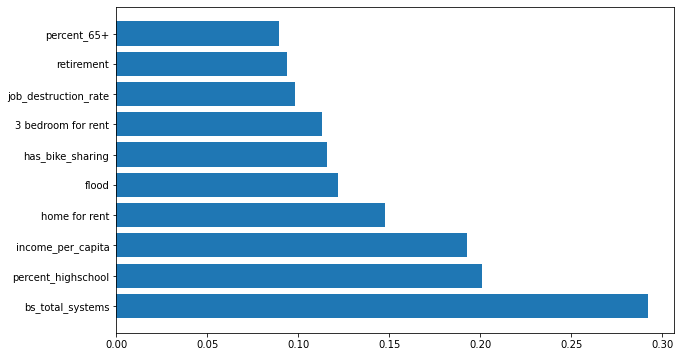


Got an mse at 0.0025 in epoch 51 and stopped training



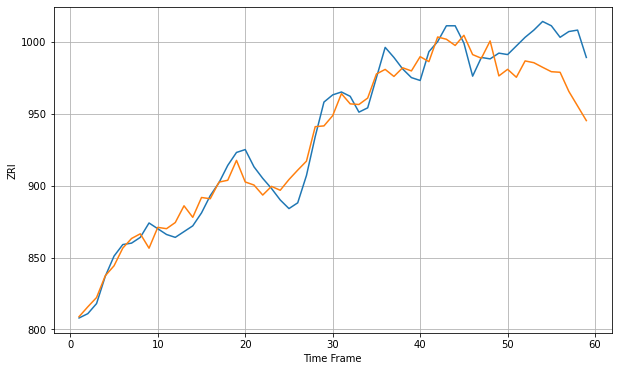

Wall time: 9.06 s
19120 10.267700779691502 30.030818005823456


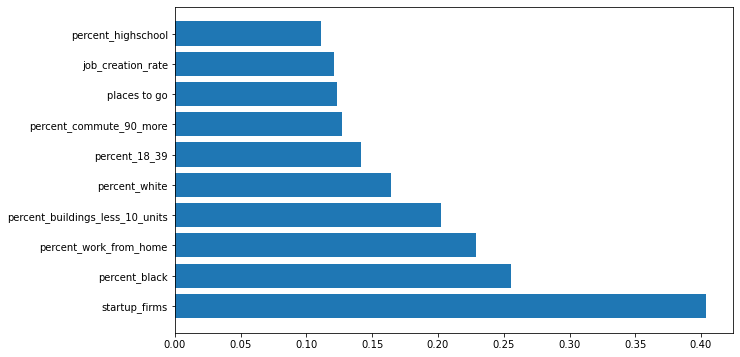


Got an mse at 0.0025 in epoch 197 and stopped training



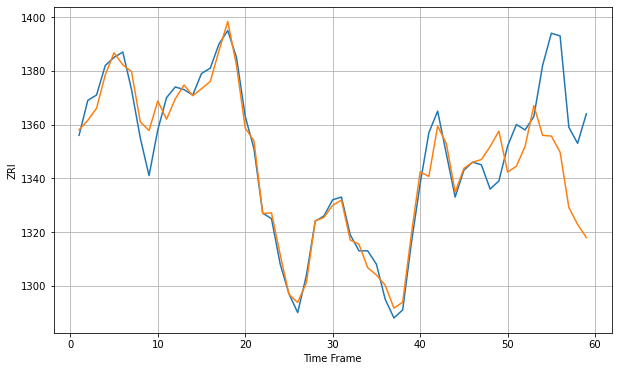

Wall time: 13 s
19121 5.270091431537199 27.265350842443244


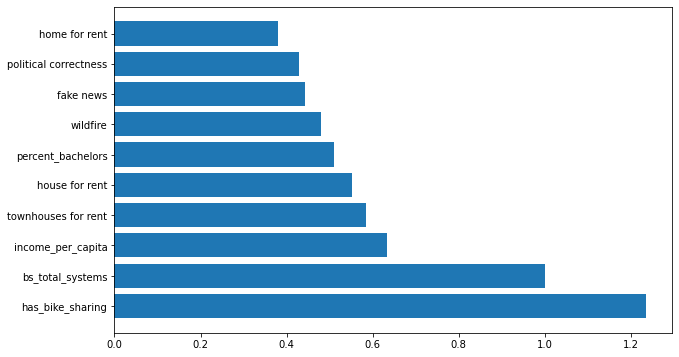


Got an mse at 0.0024 in epoch 30 and stopped training



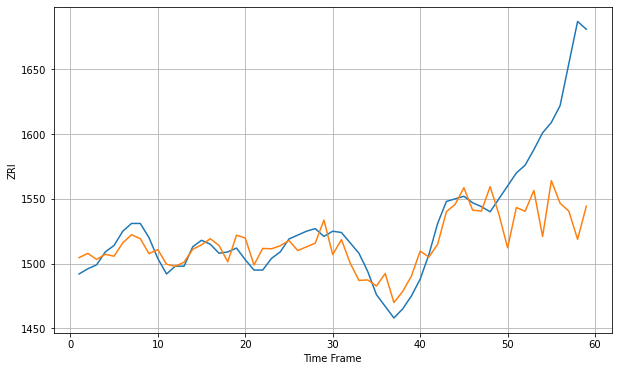

Wall time: 8.32 s
19123 10.945056726012643 81.57731149089734


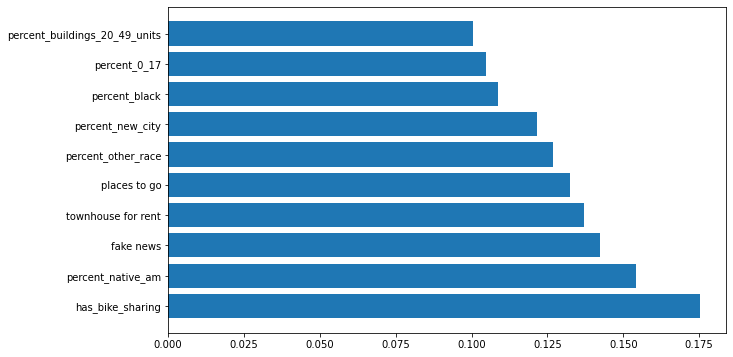


Got an mse at 0.0025 in epoch 49 and stopped training



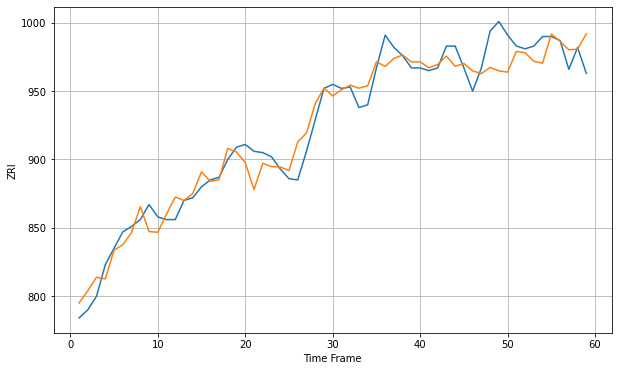

Wall time: 8.95 s
19124 10.996877924061037 19.00125703294483


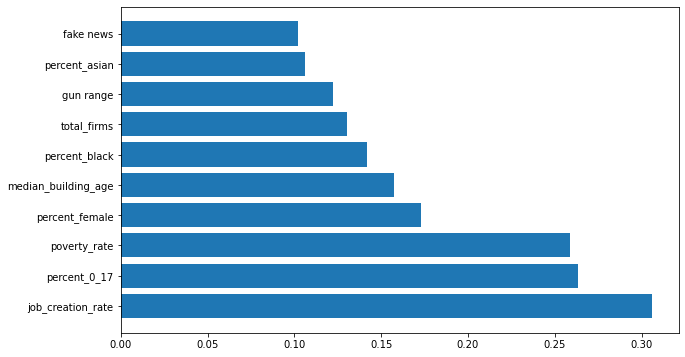


Got an mse at 0.0025 in epoch 128 and stopped training



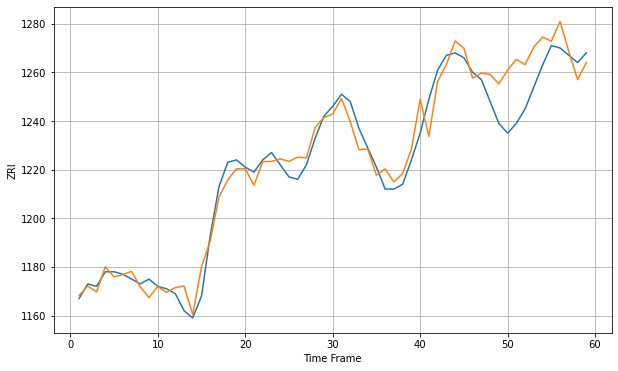

Wall time: 11.1 s
19128 5.528444535627445 14.93139684323754


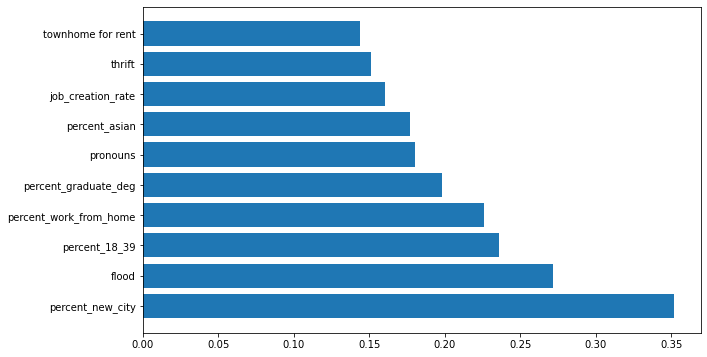


Got an mse at 0.0025 in epoch 60 and stopped training



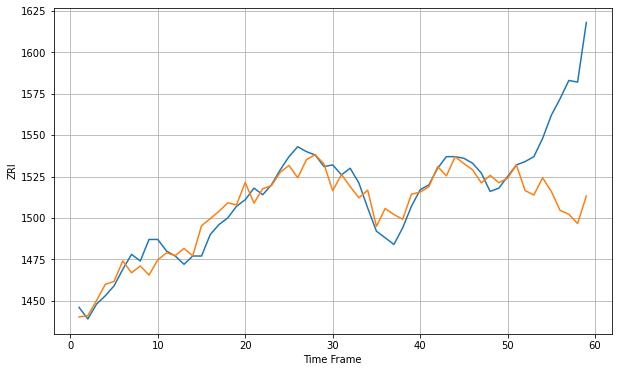

Wall time: 9.31 s
19130 8.795667296510139 52.42680779550144


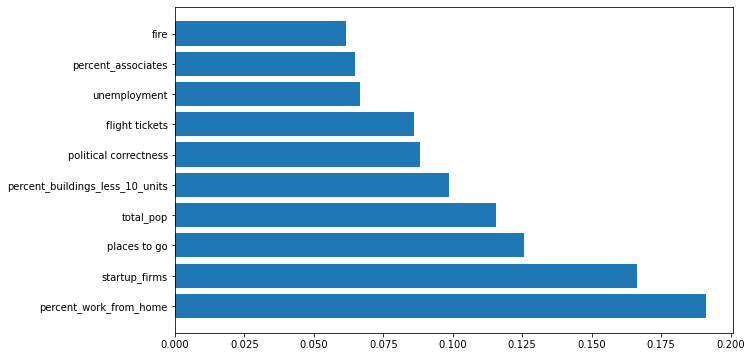


Got an mse at 0.0025 in epoch 60 and stopped training



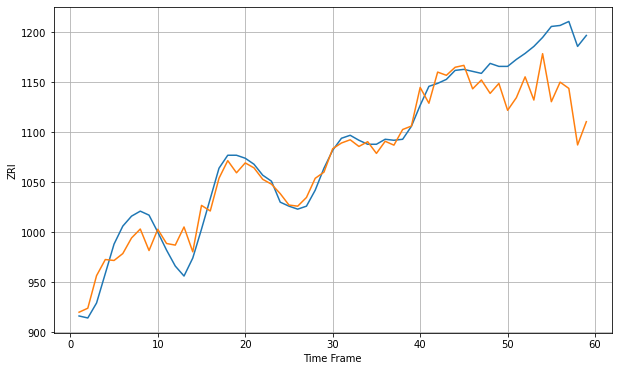

Wall time: 9.31 s
19131 14.616683876715282 56.93675369995459


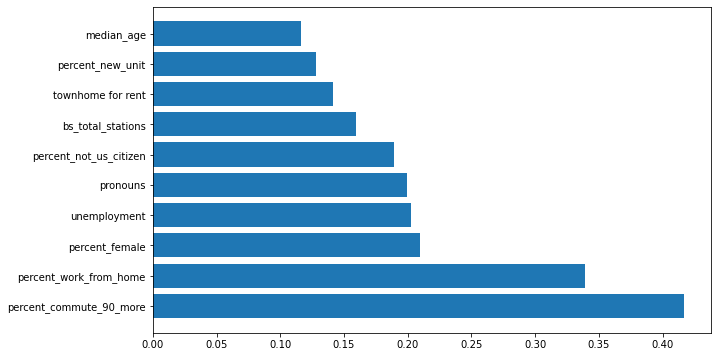


Got an mse at 0.0024 in epoch 40 and stopped training



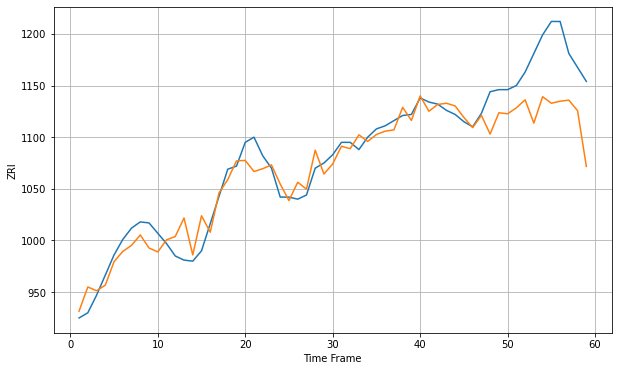

Wall time: 8.67 s
19139 13.843541293218749 53.87277368524687


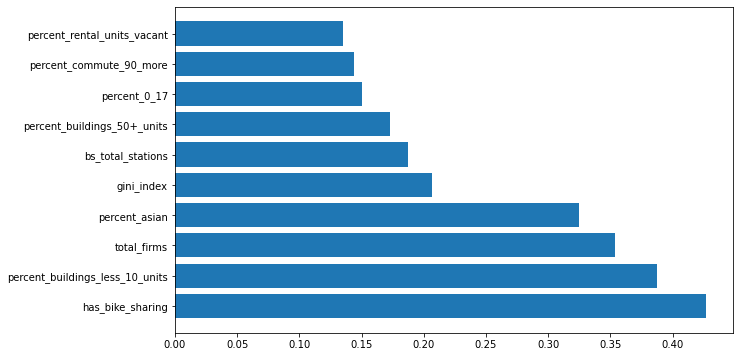


Got an mse at 0.0025 in epoch 67 and stopped training



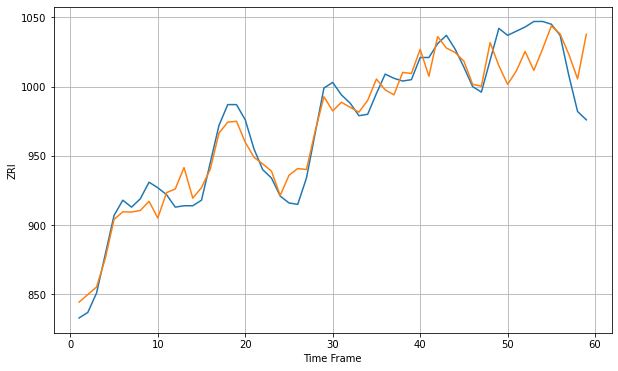

Wall time: 9.58 s
19140 10.746711153215374 28.175527153968744


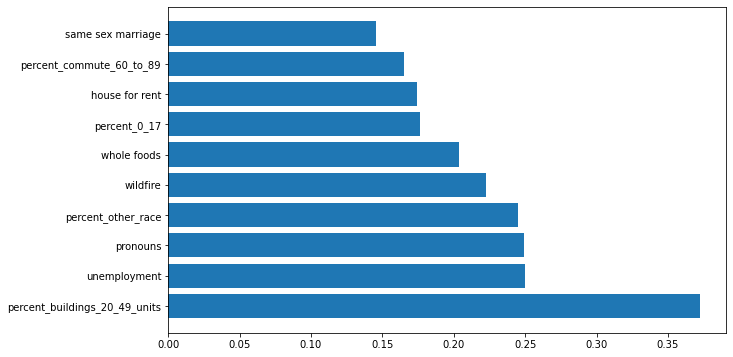


Got an mse at 0.0025 in epoch 171 and stopped training



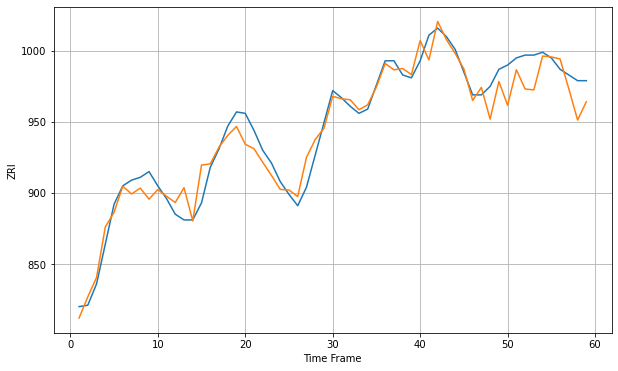

Wall time: 12.8 s
19141 9.716293179079955 17.779116614153274


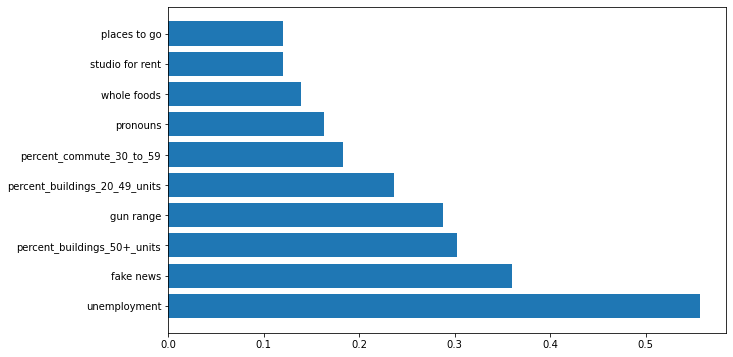


Got an mse at 0.0025 in epoch 151 and stopped training



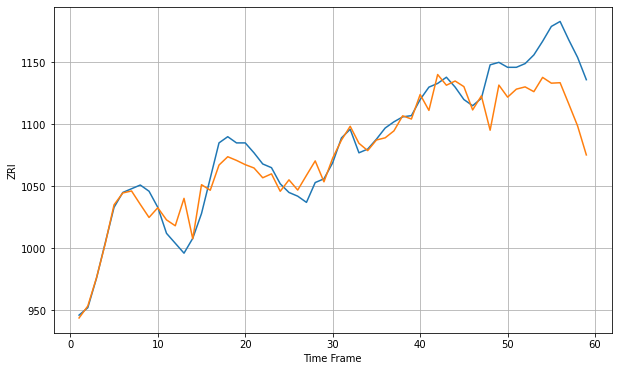

Wall time: 11.9 s
19143 12.006160378587577 40.87506557637492


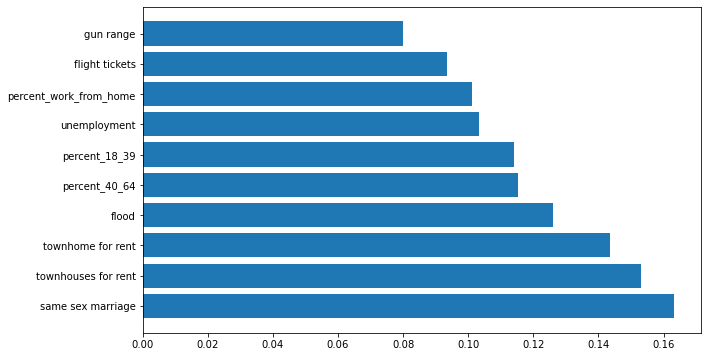


Got an mse at 0.0025 in epoch 71 and stopped training



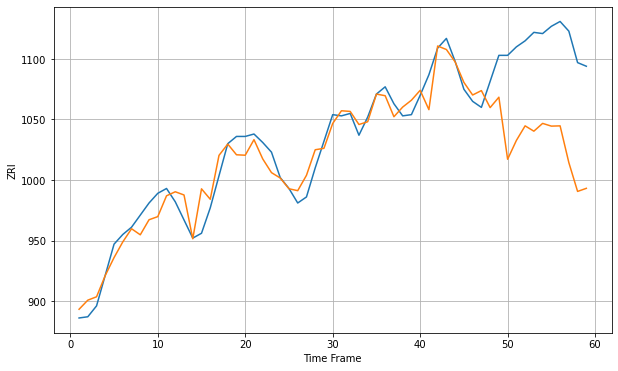

Wall time: 9.57 s
19144 12.084902844327495 81.48381682057499


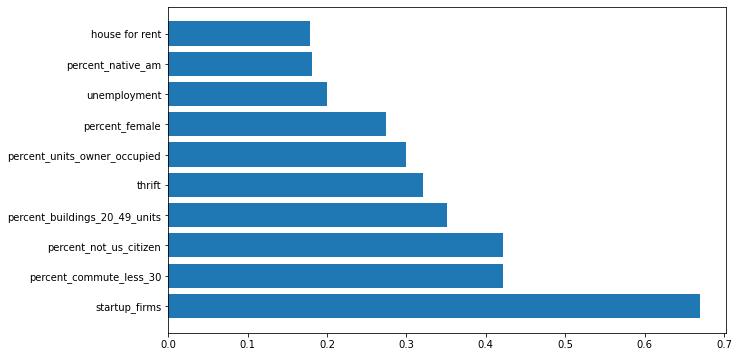


Got an mse at 0.0025 in epoch 110 and stopped training



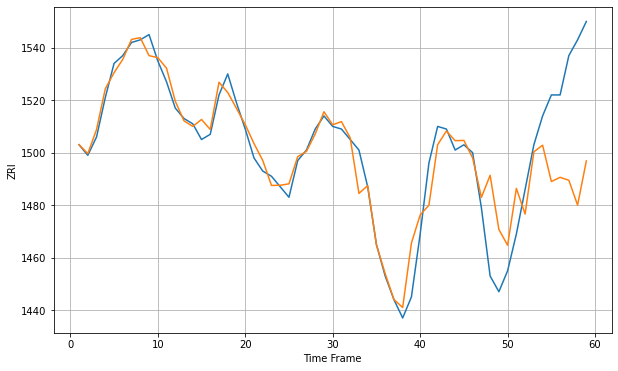

Wall time: 10.6 s
19146 5.628289971787344 33.88305046338886


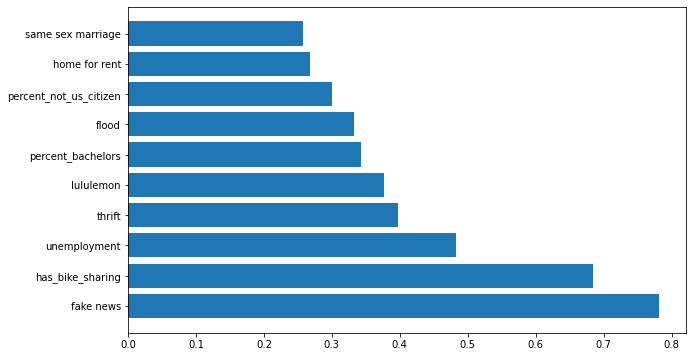


Got an mse at 0.0025 in epoch 168 and stopped training



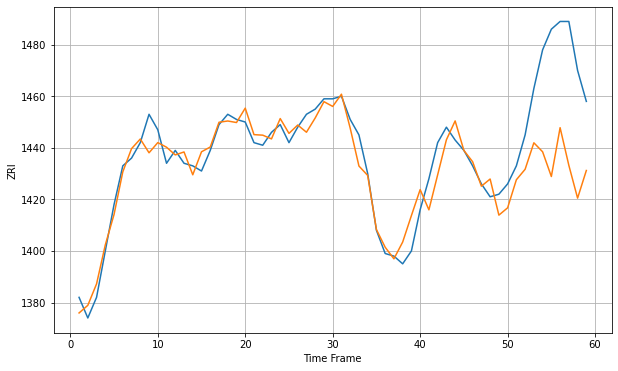

Wall time: 12.5 s
19147 5.716136790975192 33.73844109638459


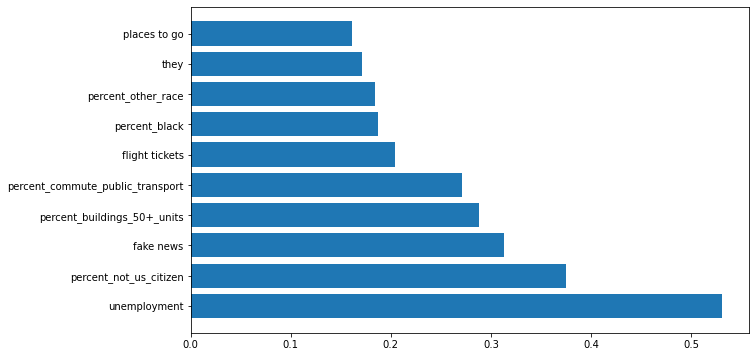


Got an mse at 0.0025 in epoch 75 and stopped training



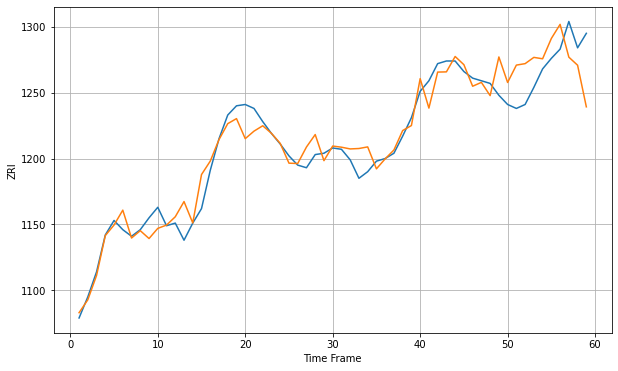

Wall time: 9.73 s
19148 11.076857487827853 26.50359857187251


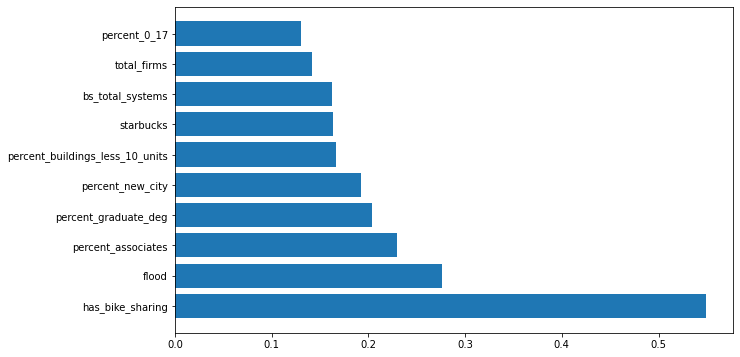


Got an mse at 0.0025 in epoch 36 and stopped training



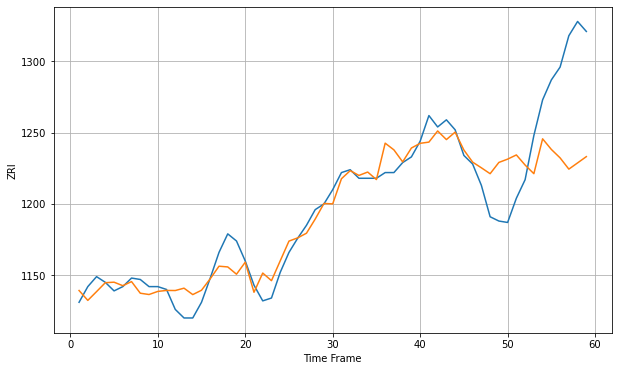

Wall time: 8.45 s
19401 10.22808568079467 57.603980346173806


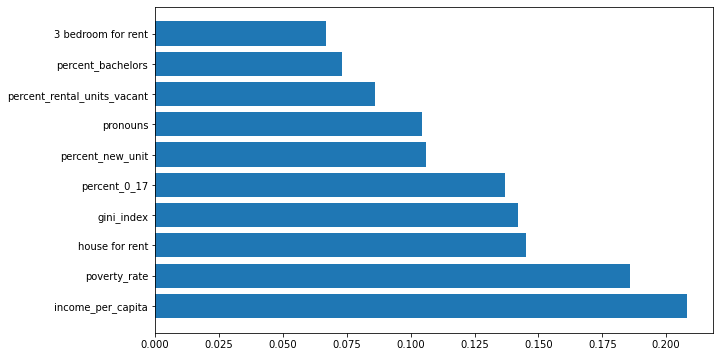


Got an mse at 0.0025 in epoch 139 and stopped training



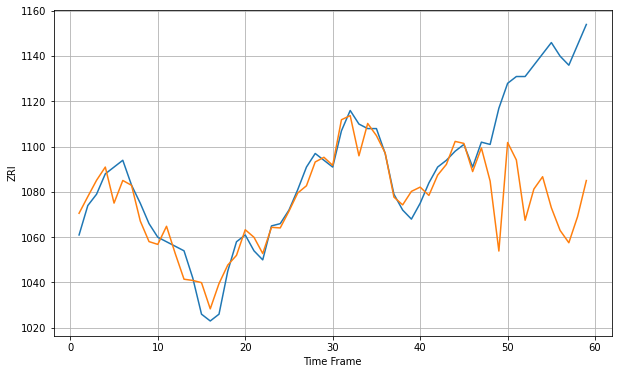

Wall time: 11.6 s
19464 6.4444024362712575 60.67560163291379


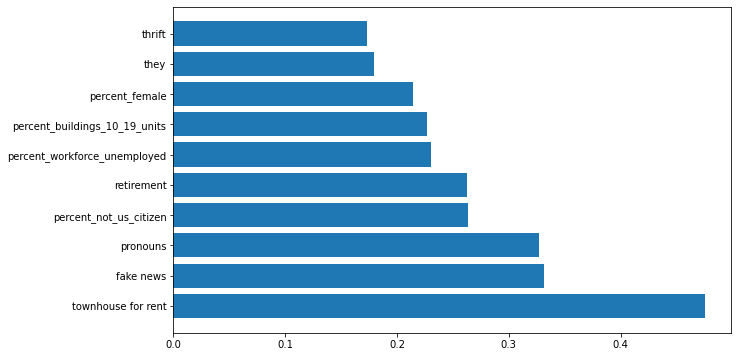


Got an mse at 0.0025 in epoch 46 and stopped training



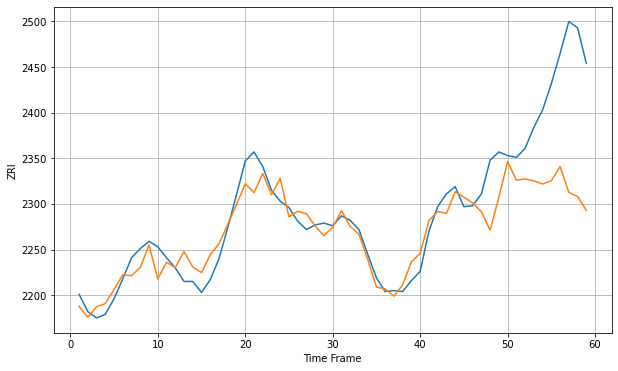

Wall time: 8.99 s
20001 15.983699394601532 108.83845833173844


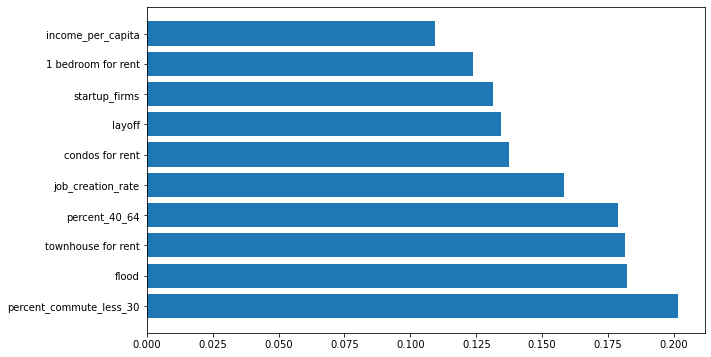


Got an mse at 0.0024 in epoch 36 and stopped training



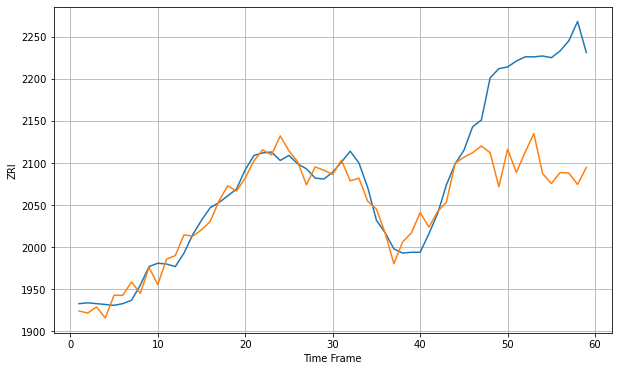

Wall time: 8.79 s
20002 16.36819021851087 135.08881492897672


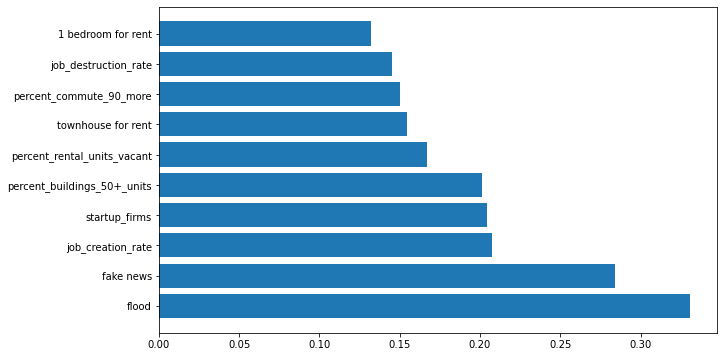


Got an mse at 0.0024 in epoch 34 and stopped training



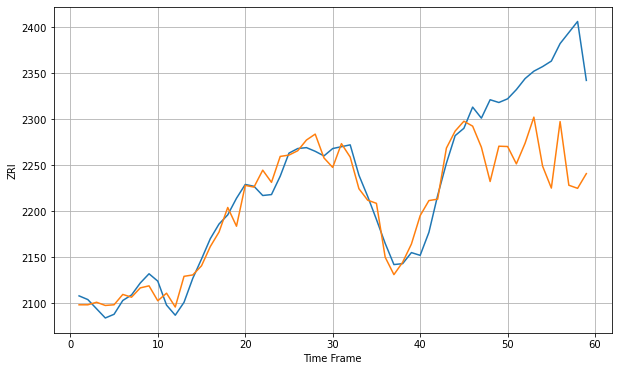

Wall time: 8.64 s
20003 15.756582675290208 106.1571117713436


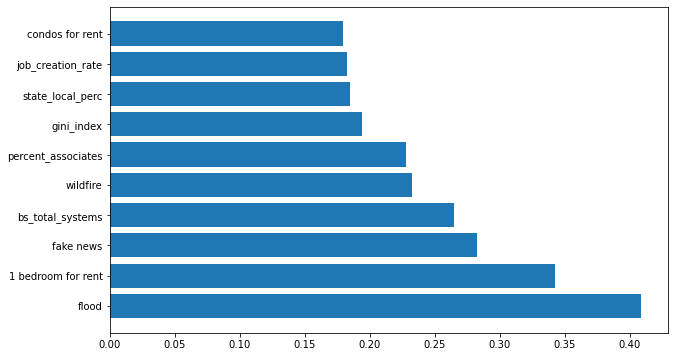


Got an mse at 0.0024 in epoch 34 and stopped training



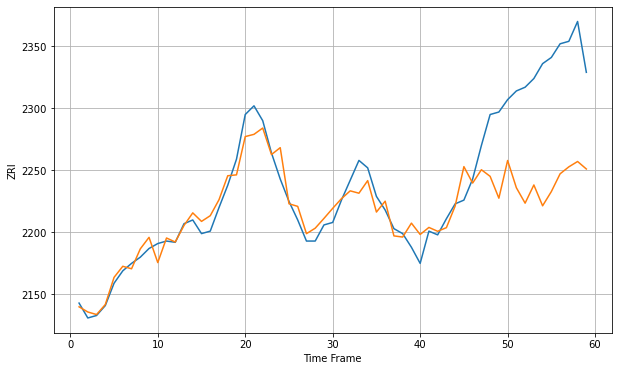

Wall time: 8.47 s
20005 11.475092132447102 89.78670144435225


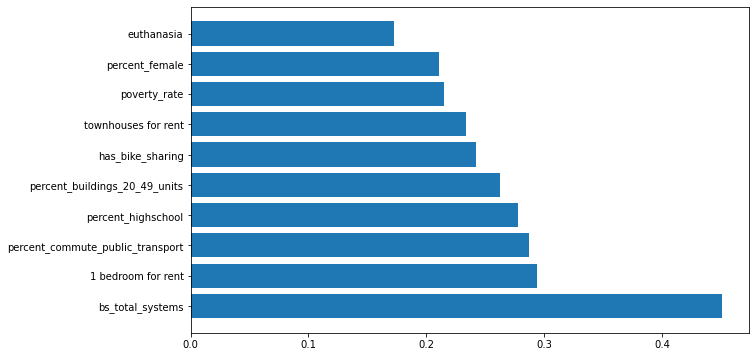


Got an mse at 0.0025 in epoch 157 and stopped training



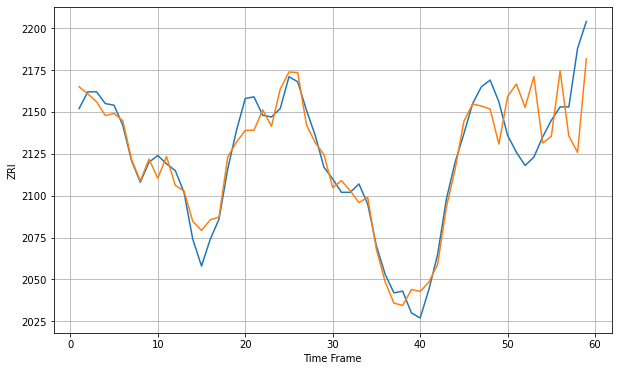

Wall time: 12.2 s
20007 8.731643493689004 31.459641613273764


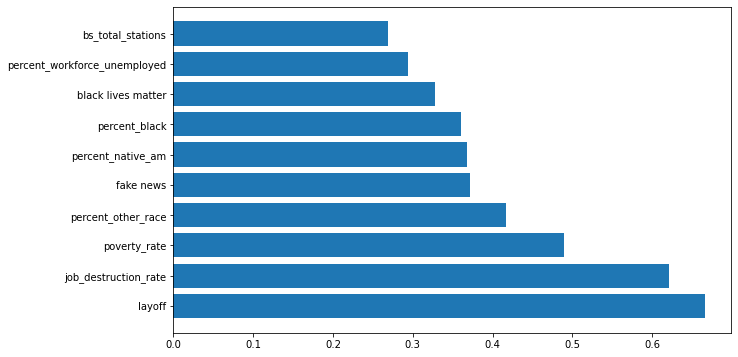


Got an mse at 0.0025 in epoch 168 and stopped training



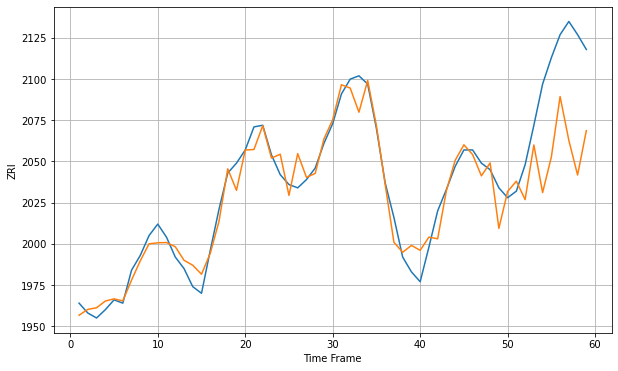

Wall time: 12.5 s
20008 8.88913401565297 46.139611737299724


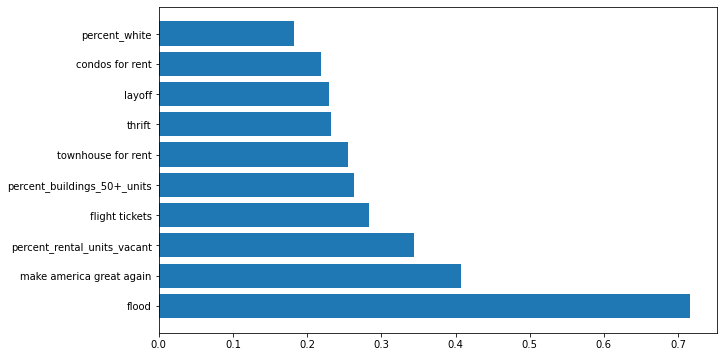


Got an mse at 0.0024 in epoch 72 and stopped training



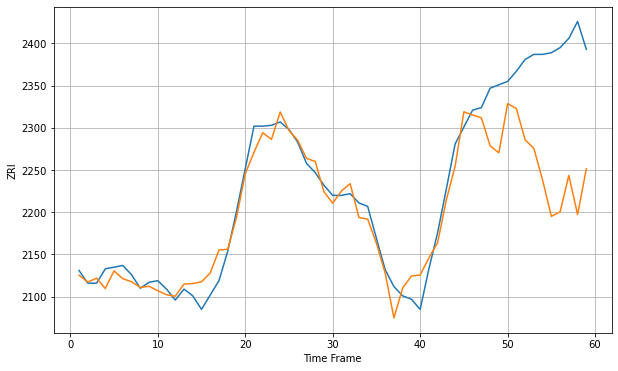

Wall time: 9.54 s
20009 16.426898447029433 138.89609326778438


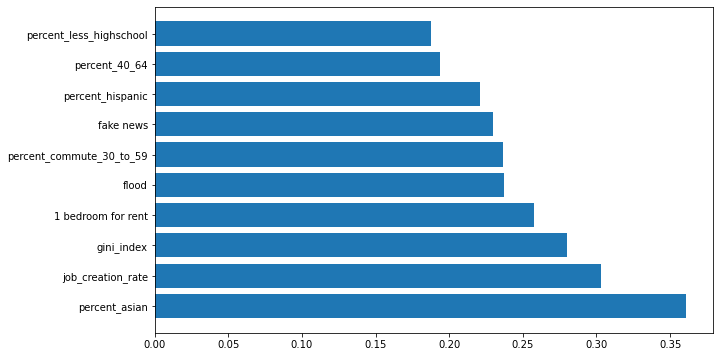


Got an mse at 0.0024 in epoch 149 and stopped training



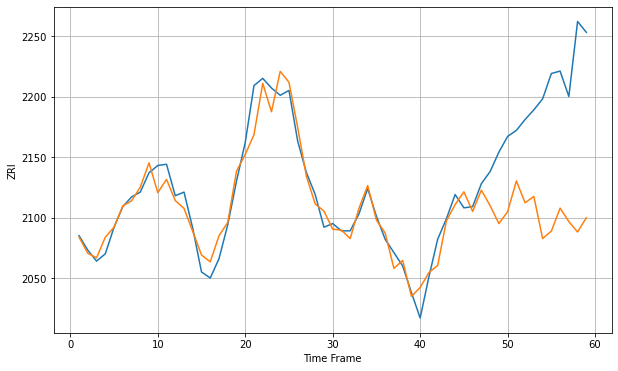

Wall time: 11.8 s
20010 11.897349249287512 102.97767181231862


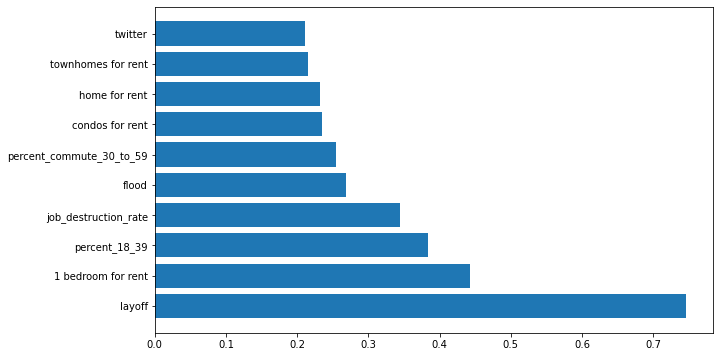


Got an mse at 0.0025 in epoch 57 and stopped training



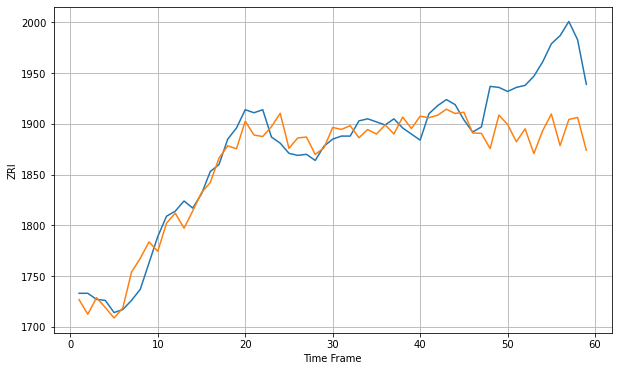

Wall time: 8.97 s
20011 14.093460044742415 68.70887419236215


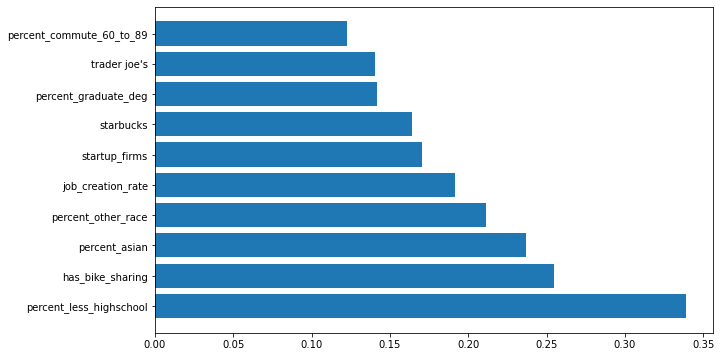


Got an mse at 0.0024 in epoch 130 and stopped training



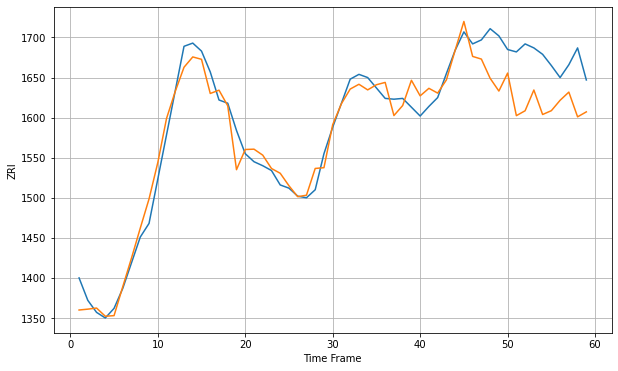

Wall time: 11.1 s
20019 17.658625993633603 61.405449559082655


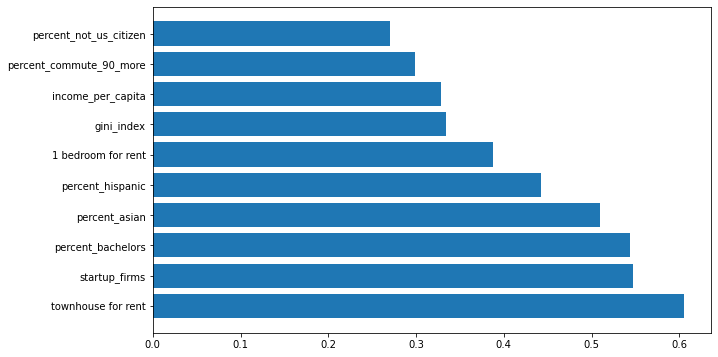


Got an mse at 0.0025 in epoch 71 and stopped training



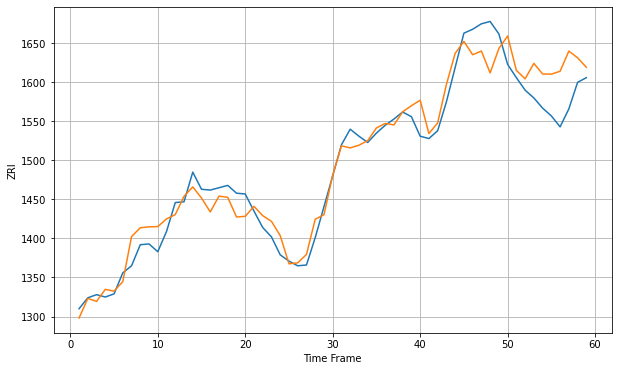

Wall time: 9.52 s
20020 18.674879576857933 45.43933359449865


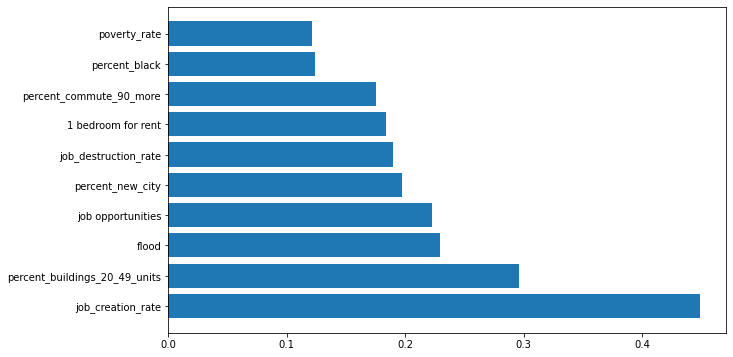


Got an mse at 0.0025 in epoch 47 and stopped training



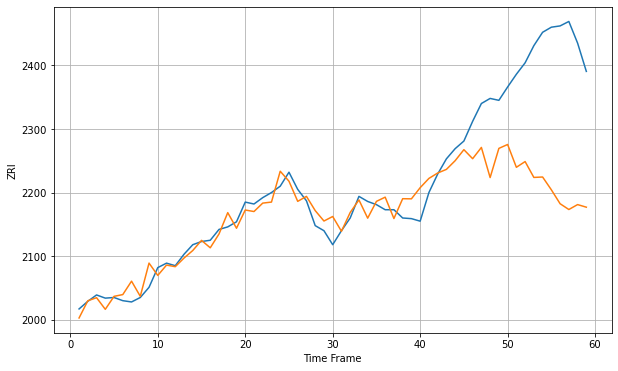

Wall time: 8.84 s
20024 22.756009379653616 206.2775822702745


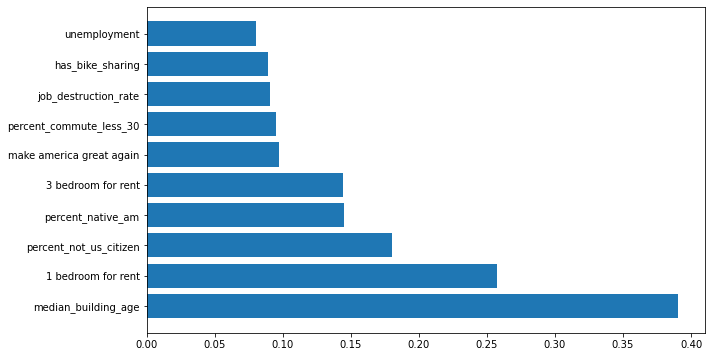


Got an mse at 0.0024 in epoch 102 and stopped training



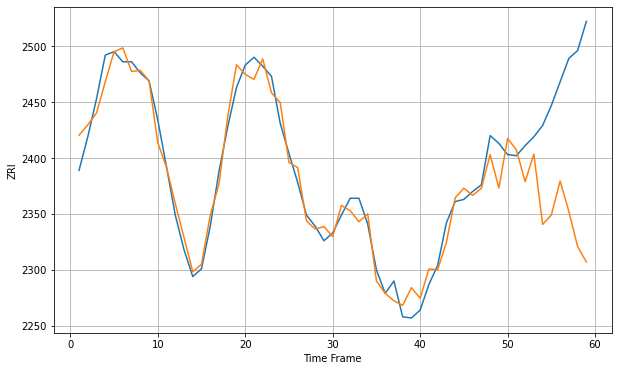

Wall time: 10.3 s
20037 12.794003736155577 101.74954934770953


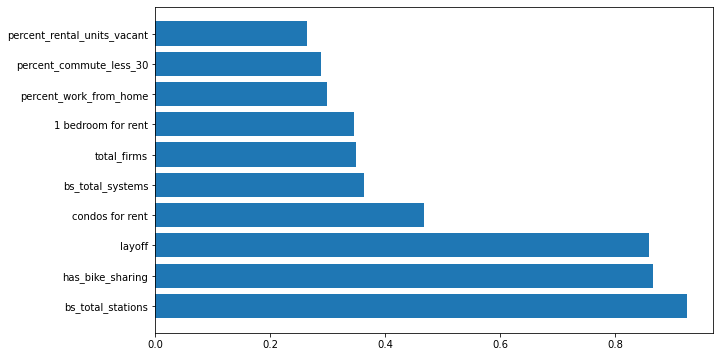


Got an mse at 0.0024 in epoch 32 and stopped training



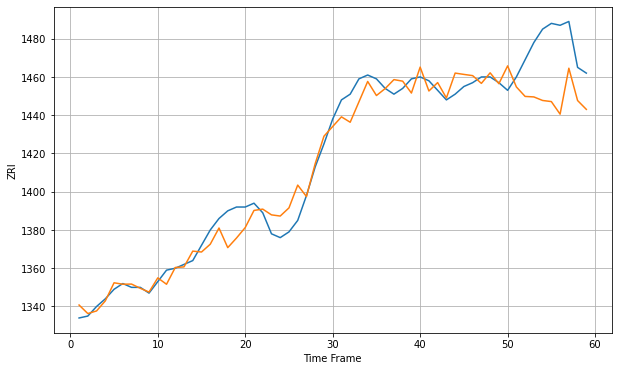

Wall time: 8.55 s
20109 7.554201141283608 25.57813253371849


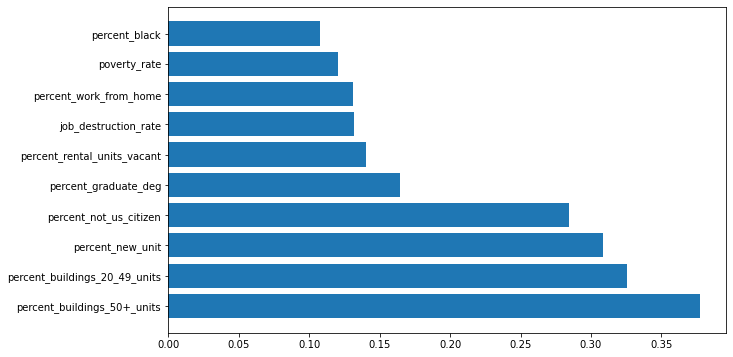


Got an mse at 0.0025 in epoch 71 and stopped training



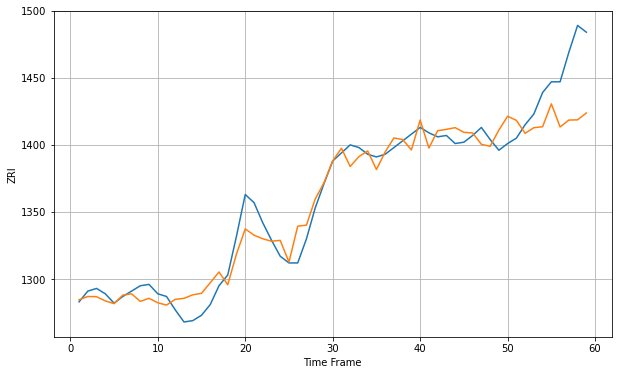

Wall time: 9.62 s
20110 10.934625332277507 34.35788525877628


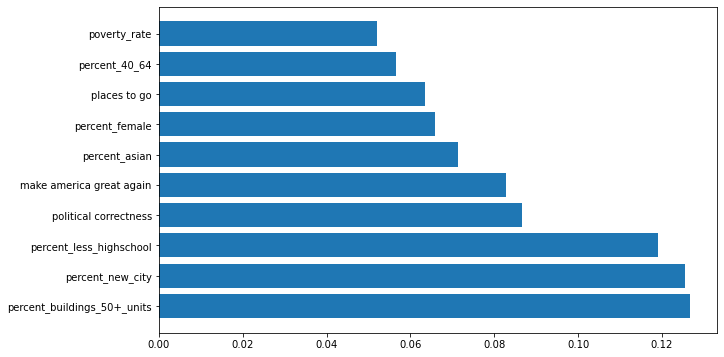


Got an mse at 0.0025 in epoch 38 and stopped training



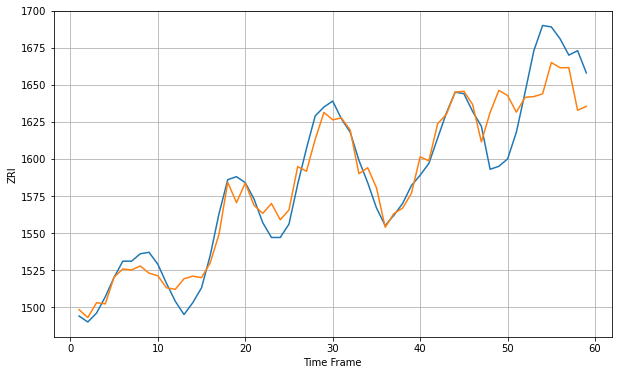

Wall time: 8.46 s
20147 9.729856386251193 32.09393568195302


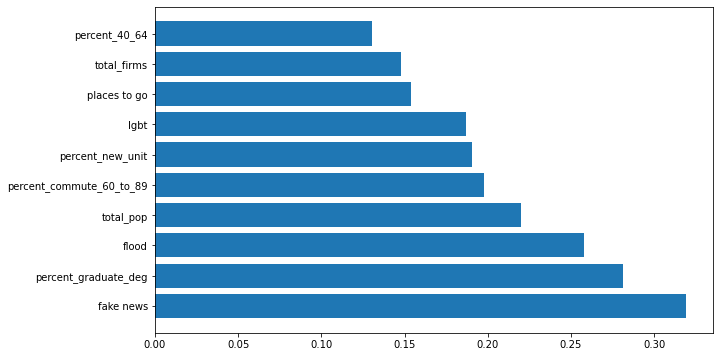


Got an mse at 0.0024 in epoch 60 and stopped training



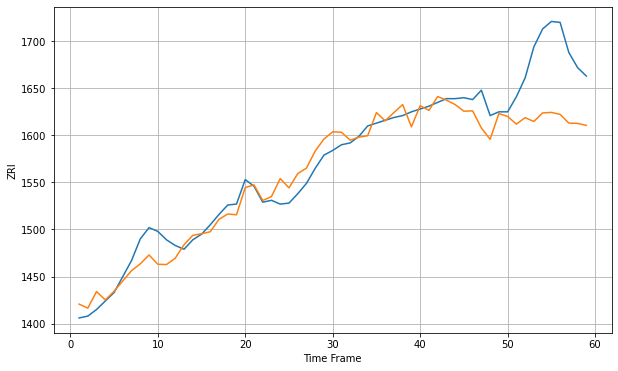

Wall time: 9.09 s
20175 14.961474841264028 63.42430662260472


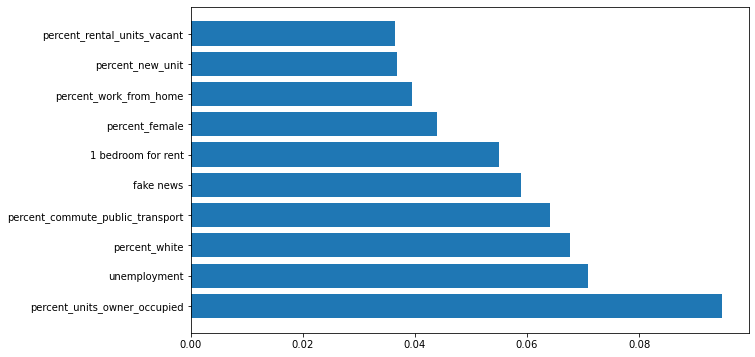


Got an mse at 0.0025 in epoch 34 and stopped training



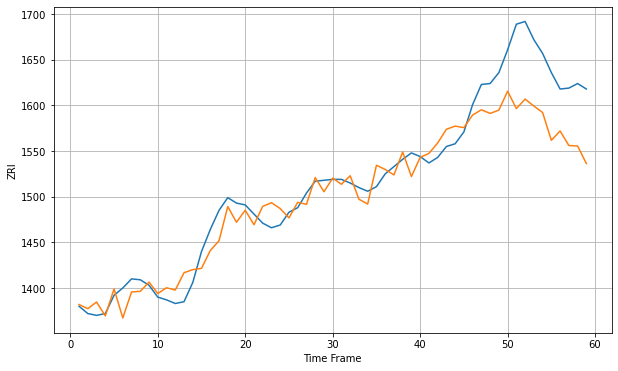

Wall time: 8.4 s
20176 15.801102037951404 66.46289779127201


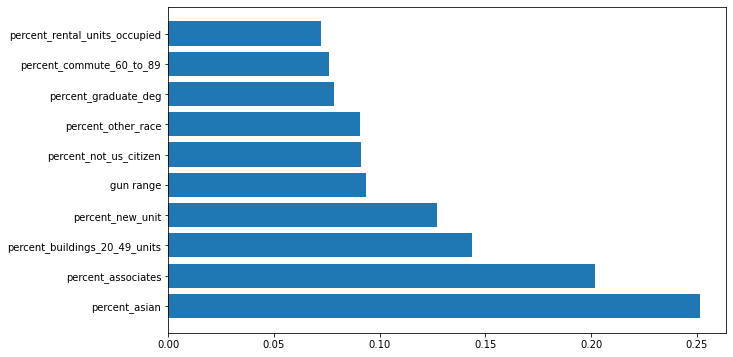


Got an mse at 0.0025 in epoch 111 and stopped training



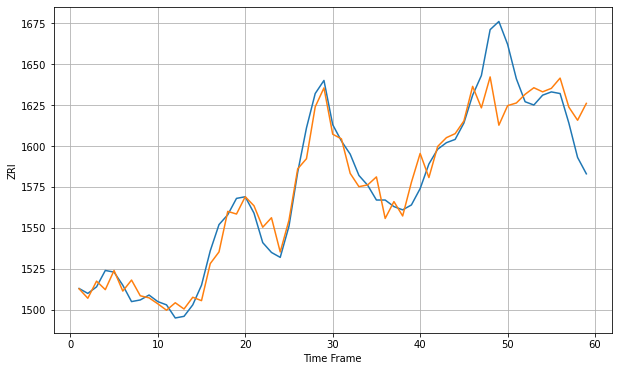

Wall time: 10.6 s
20740 8.965124345386808 27.60608082504096


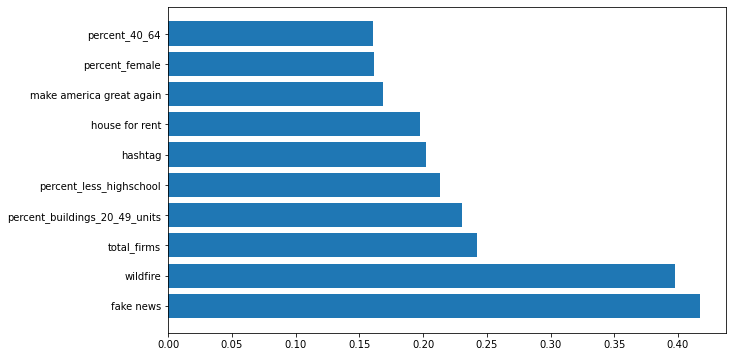


Got an mse at 0.0024 in epoch 93 and stopped training



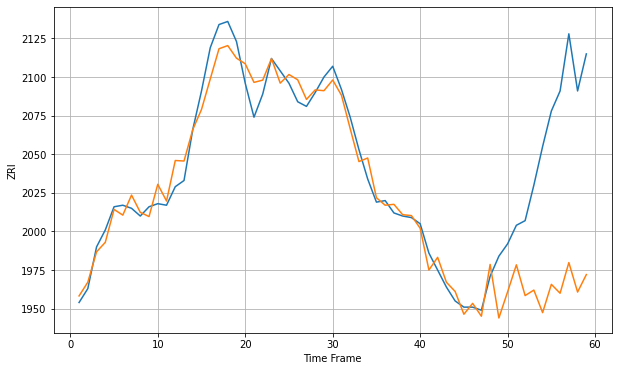

Wall time: 10.1 s
20814 9.132621162288704 96.13896323063302


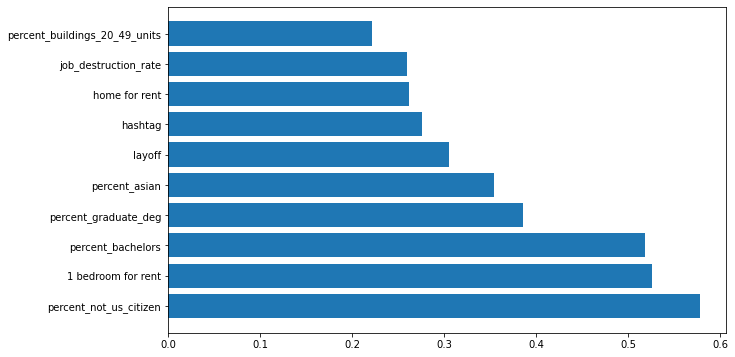


Got an mse at 0.0025 in epoch 70 and stopped training



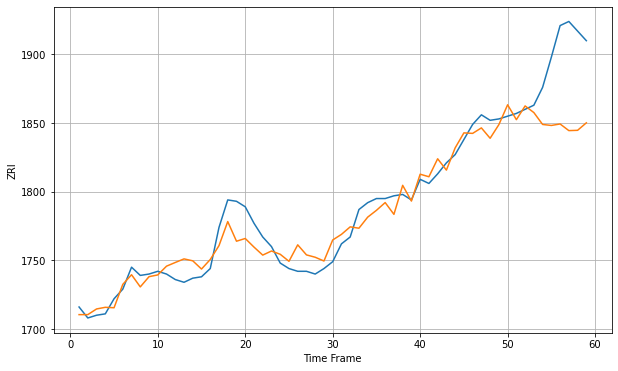

Wall time: 9.52 s
20850 10.657590627143476 44.520015465095504


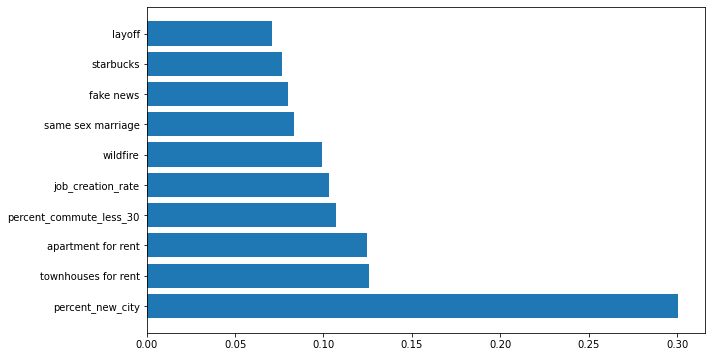


Got an mse at 0.0025 in epoch 55 and stopped training



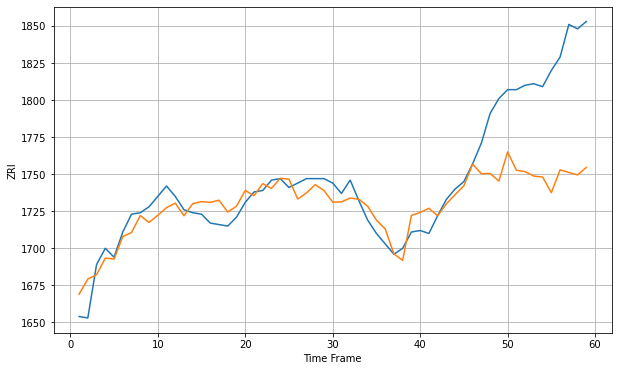

Wall time: 9.27 s
20852 9.855452198829703 72.11672158687992


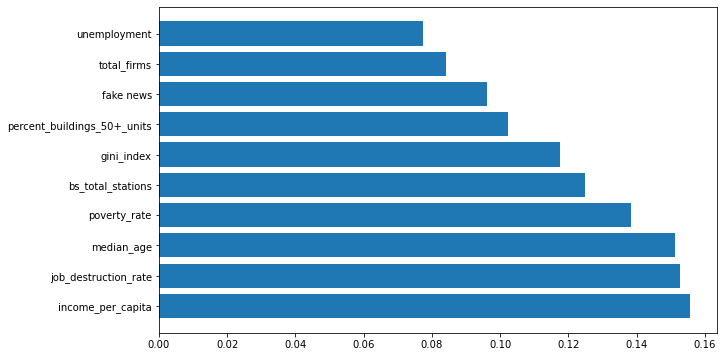


Got an mse at 0.0025 in epoch 39 and stopped training



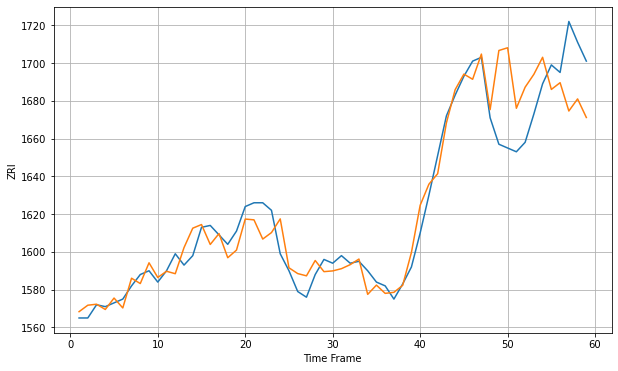

Wall time: 8.57 s
20878 7.829404272272229 31.032363982308798


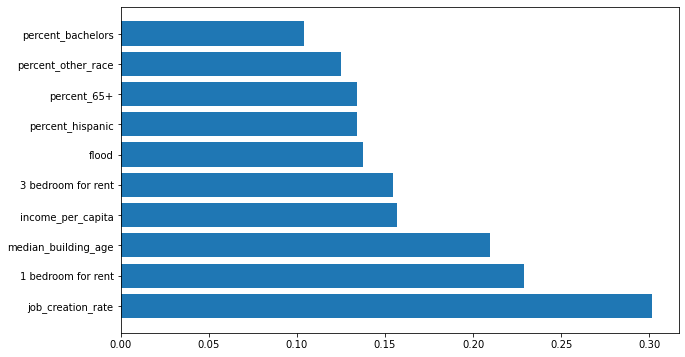


Got an mse at 0.0024 in epoch 64 and stopped training



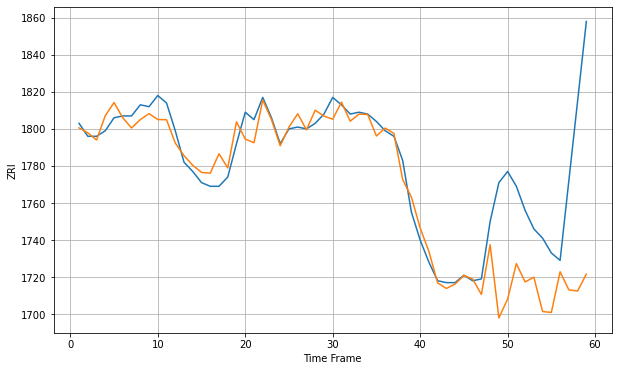

Wall time: 9.42 s
20902 6.791678795415102 64.15819452795638


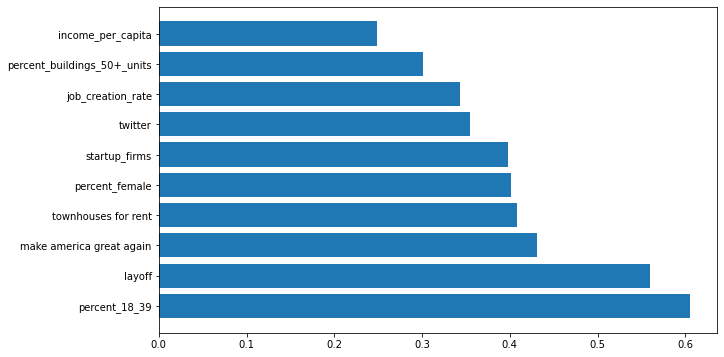


Got an mse at 0.0025 in epoch 50 and stopped training



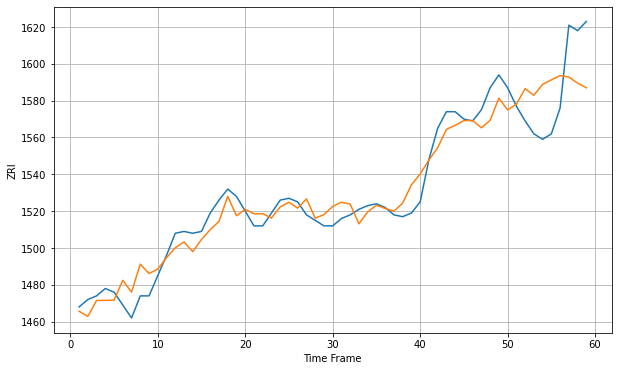

Wall time: 8.71 s
20906 7.935505389754177 22.95675993362769


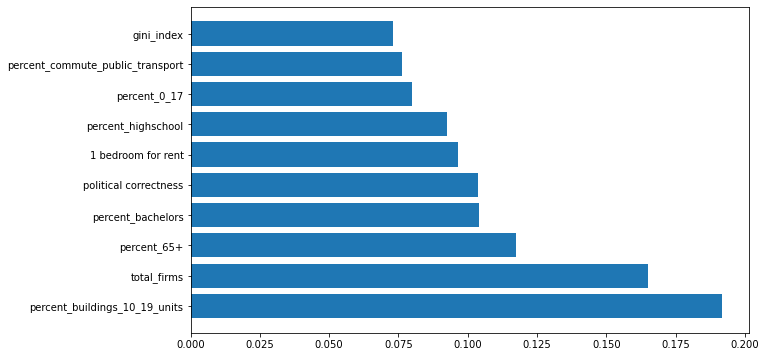


Got an mse at 0.0025 in epoch 55 and stopped training



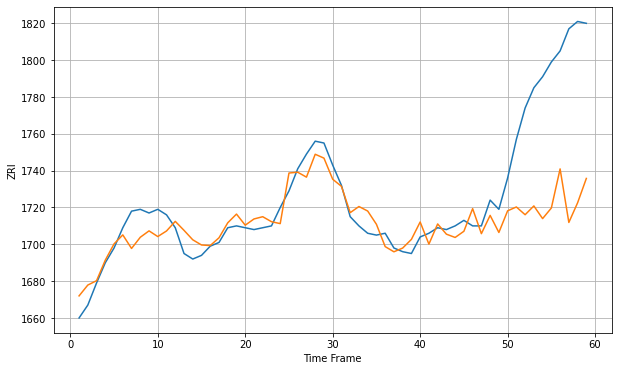

Wall time: 9.19 s
20910 7.952410614994236 66.79438785000053


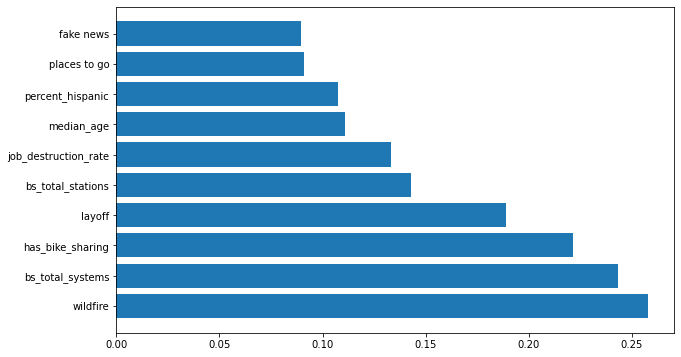


Got an mse at 0.0025 in epoch 70 and stopped training



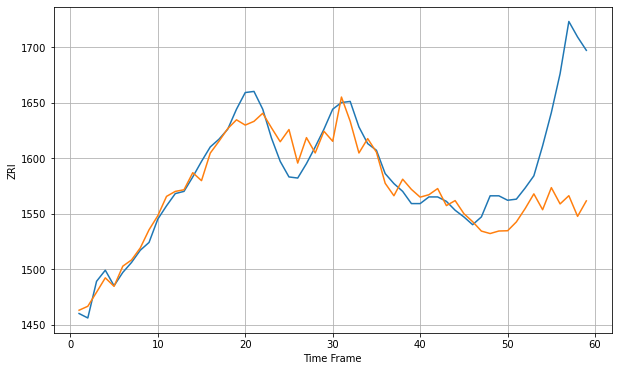

Wall time: 9.4 s
21043 13.157412157195585 88.81095132364247


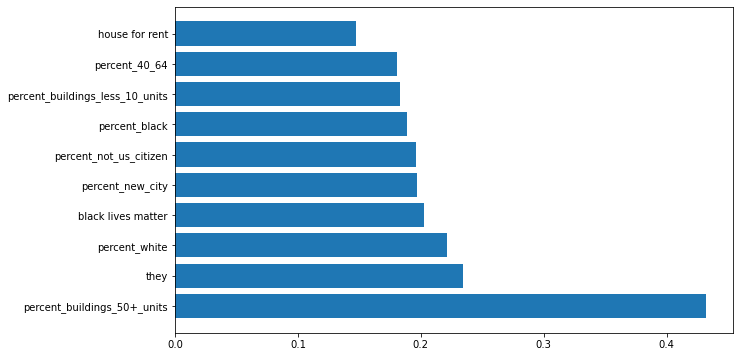


Got an mse at 0.0025 in epoch 79 and stopped training



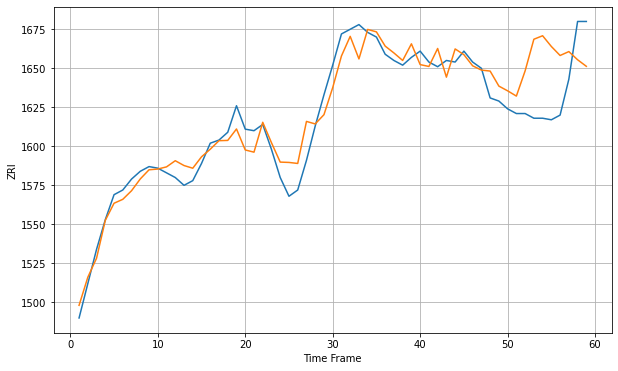

Wall time: 9.98 s
21044 9.686841459764688 31.82542301702256


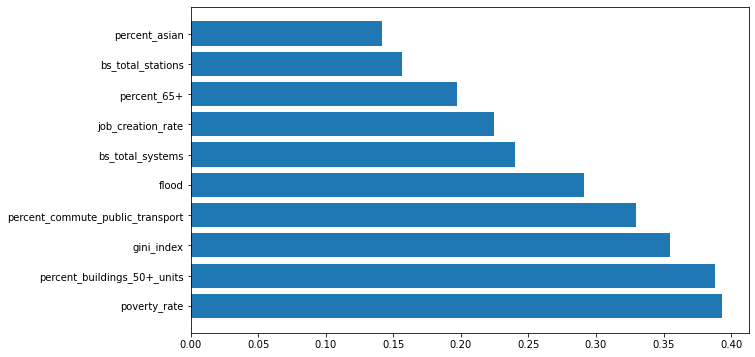


Got an mse at 0.0025 in epoch 88 and stopped training



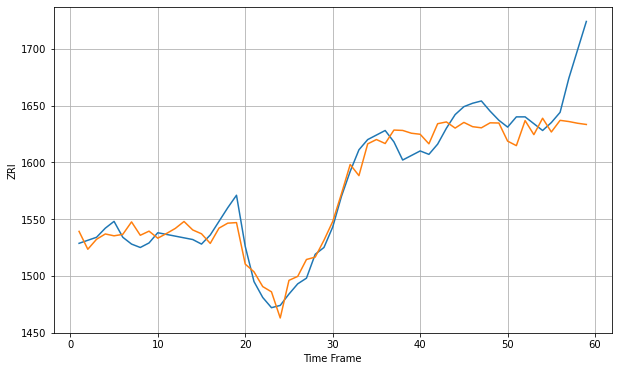

Wall time: 10.1 s
21046 12.531152702335707 35.46700941800804


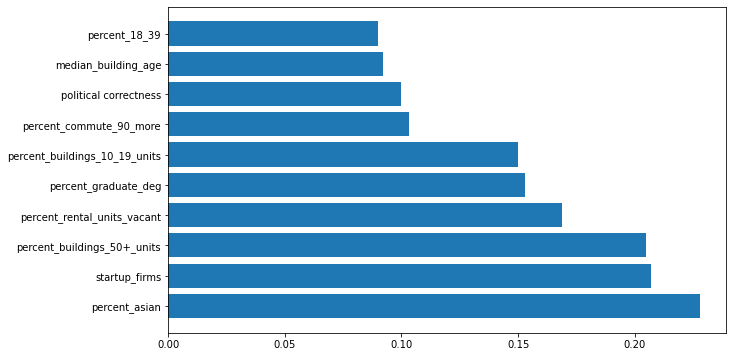


Got an mse at 0.0024 in epoch 68 and stopped training



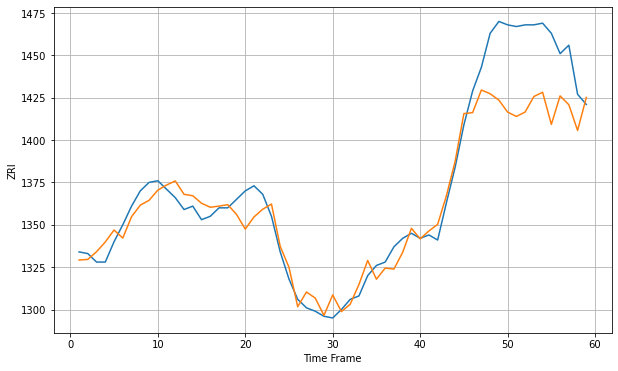

Wall time: 10.5 s
21061 8.453564552479914 41.04368282057975


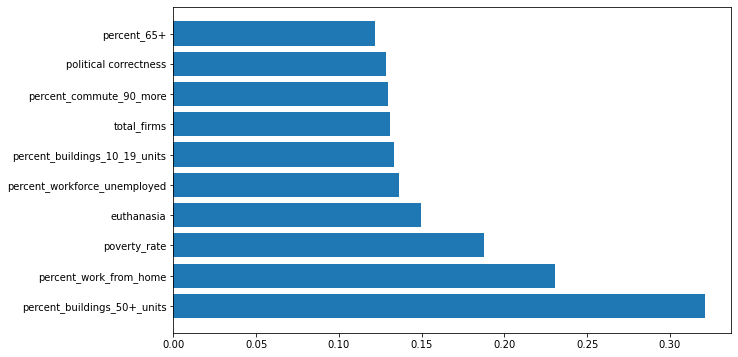


Got an mse at 0.0024 in epoch 31 and stopped training



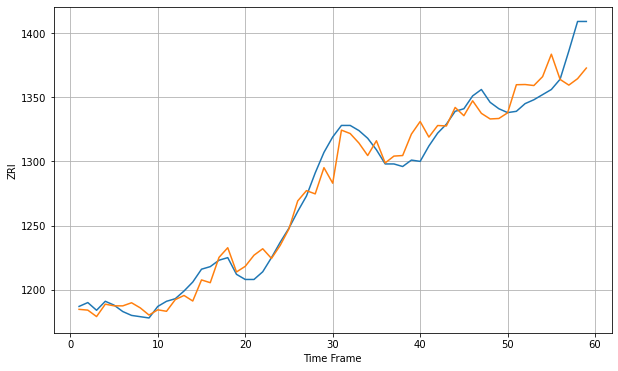

Wall time: 9.47 s
21117 11.069227348662128 22.287537319111124


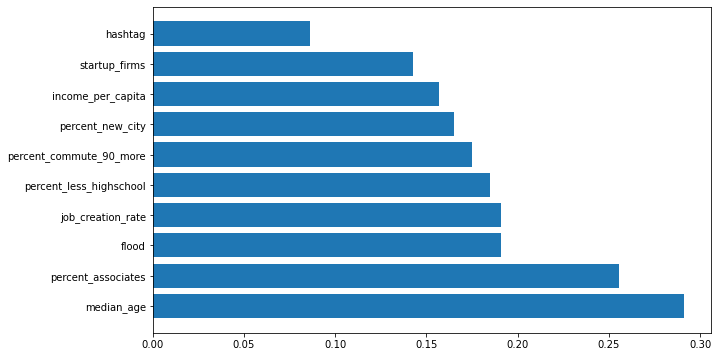


Got an mse at 0.0025 in epoch 117 and stopped training



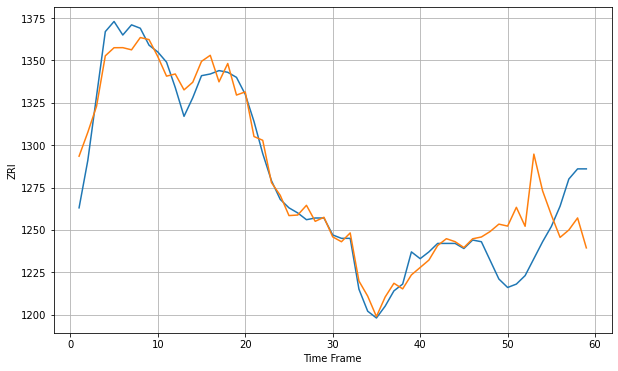

Wall time: 12.2 s
21202 8.650291278573897 34.83808390062611


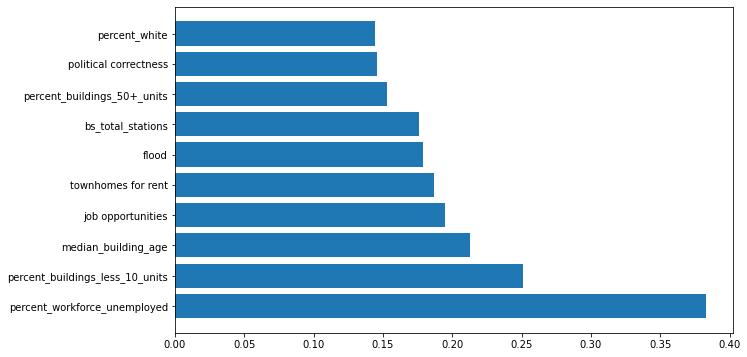


Got an mse at 0.0025 in epoch 79 and stopped training



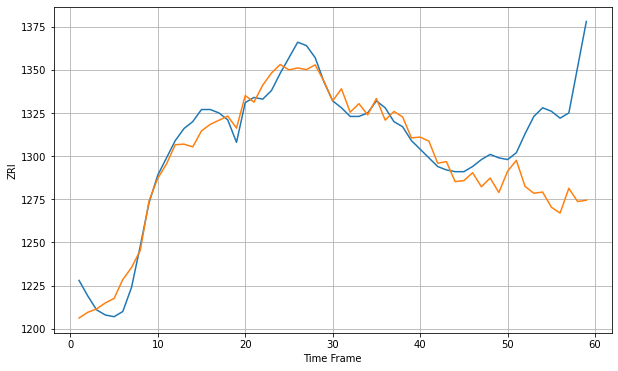

Wall time: 10.5 s
21204 8.423667212365585 50.60739426724354


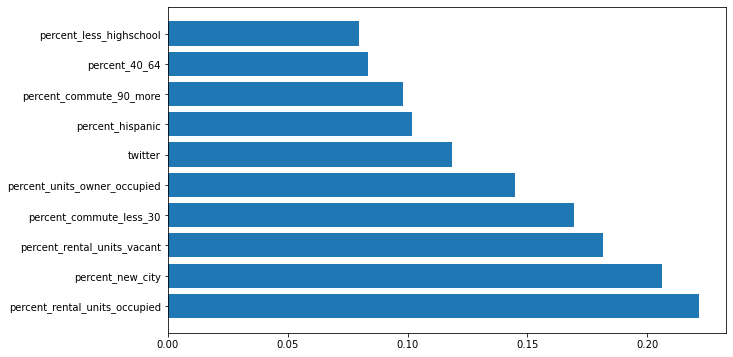


Got an mse at 0.0025 in epoch 269 and stopped training



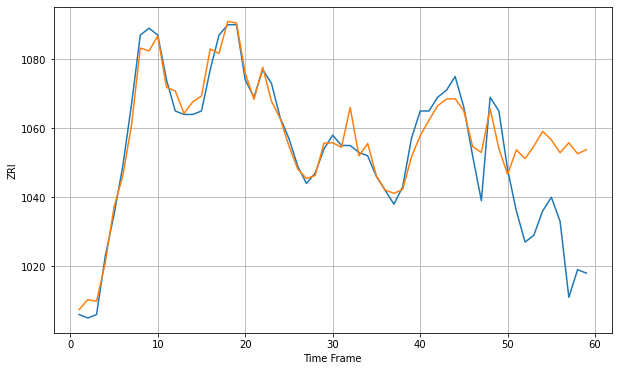

Wall time: 16 s
21217 4.198894427464488 24.700989614186753


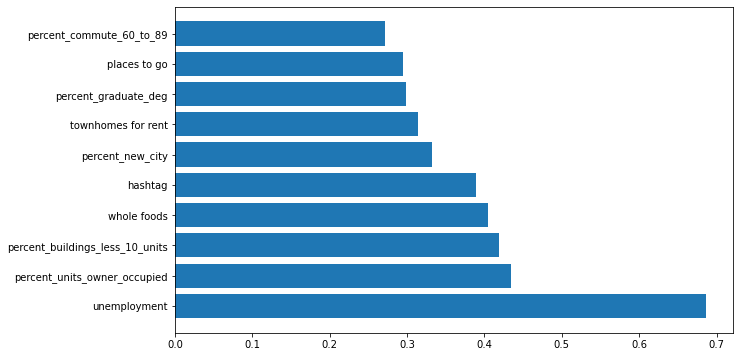


Got an mse at 0.0025 in epoch 113 and stopped training



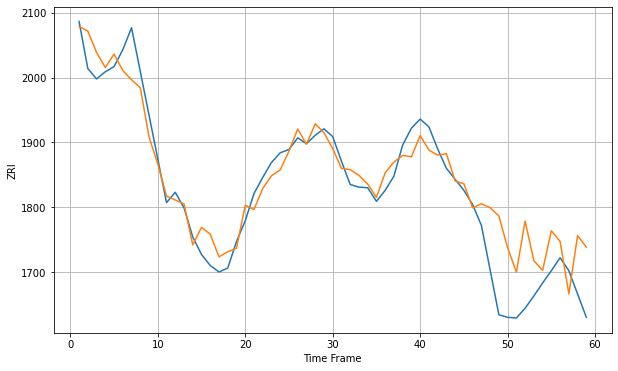

Wall time: 11.2 s
21231 26.23335178648456 89.4838043836201


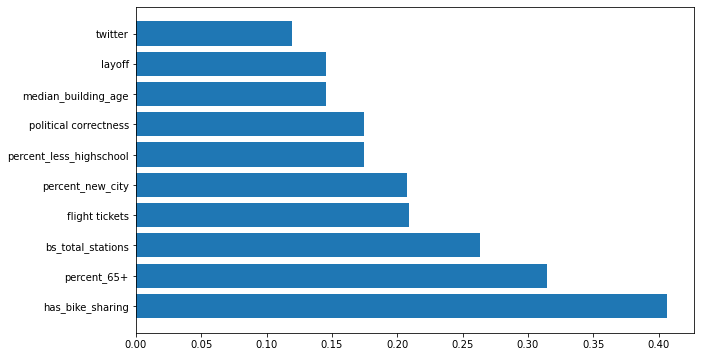


Got an mse at 0.0025 in epoch 95 and stopped training



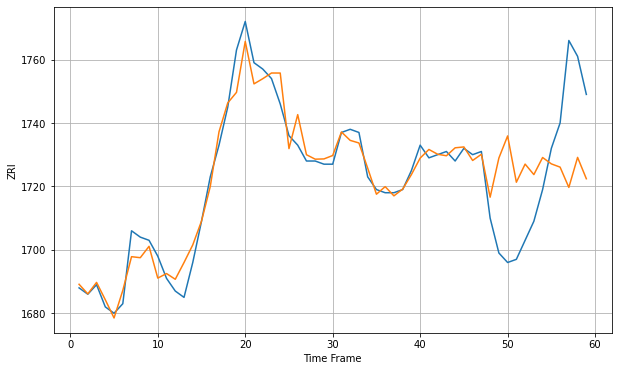

Wall time: 11.6 s
22030 4.526650628870808 25.989150579045837


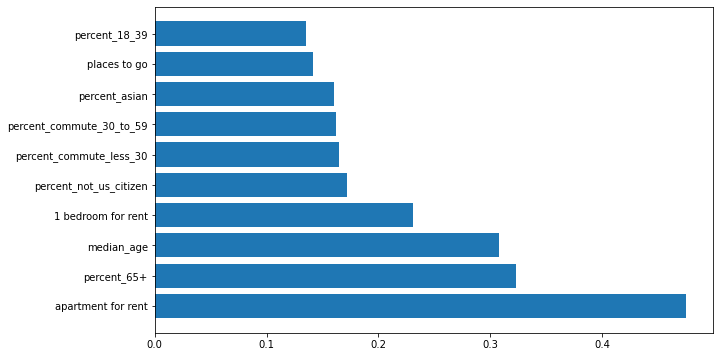


Got an mse at 0.0024 in epoch 114 and stopped training



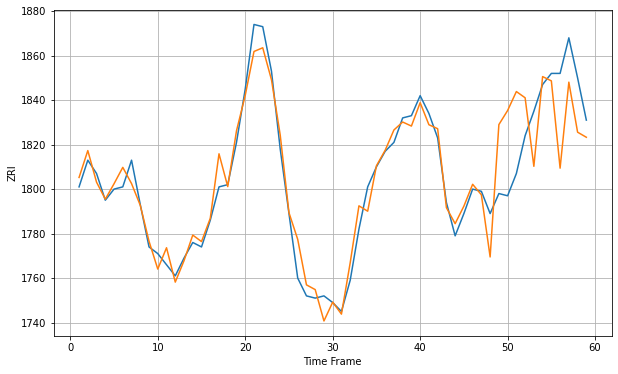

Wall time: 11.4 s
22031 6.290187490290217 25.757839259275393


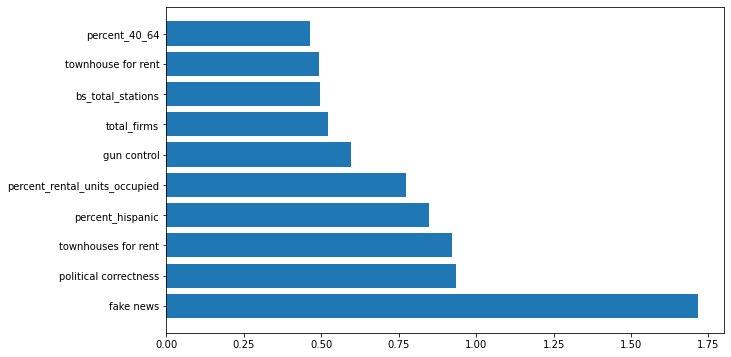


Got an mse at 0.0025 in epoch 38 and stopped training



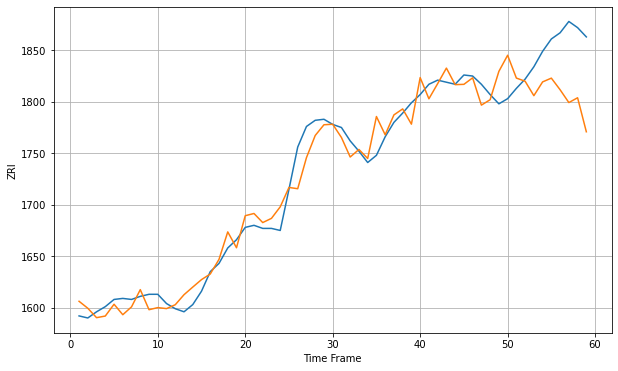

Wall time: 9.31 s
22033 14.129368583361183 48.6622331053173


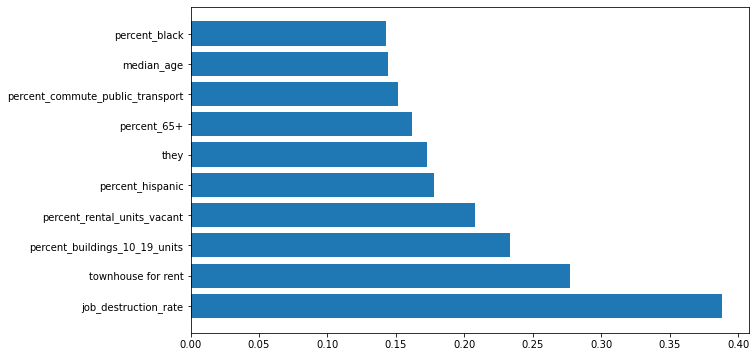


Got an mse at 0.0025 in epoch 72 and stopped training



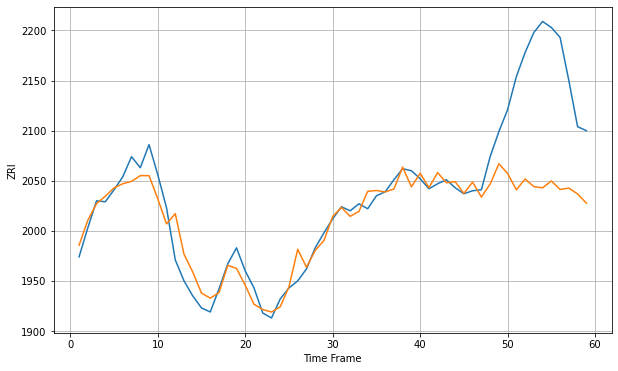

Wall time: 10.1 s
22102 14.405266547374552 113.1241394597035


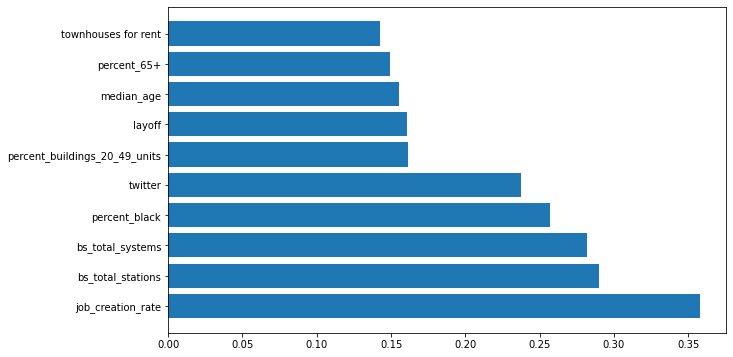


Got an mse at 0.0025 in epoch 82 and stopped training



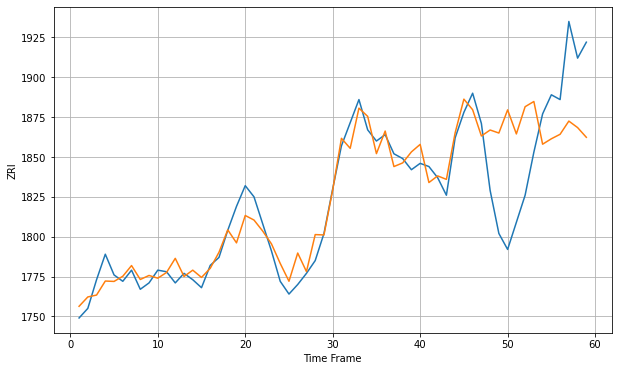

Wall time: 10.3 s
22180 9.388967186440246 50.991416095722094


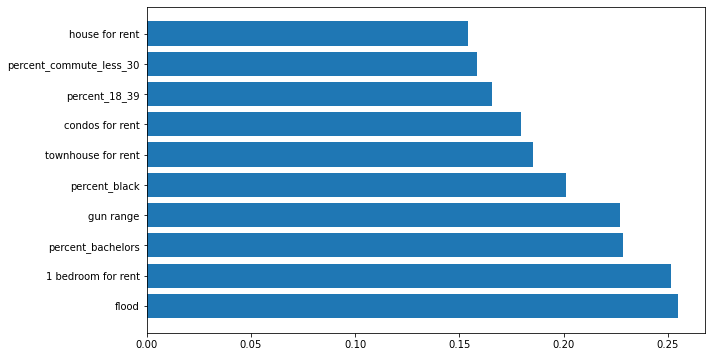


Got an mse at 0.0025 in epoch 89 and stopped training



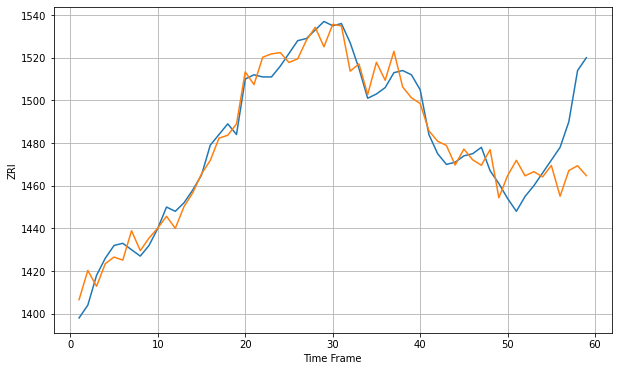

Wall time: 10.4 s
22191 6.853328714394995 24.27507717171651


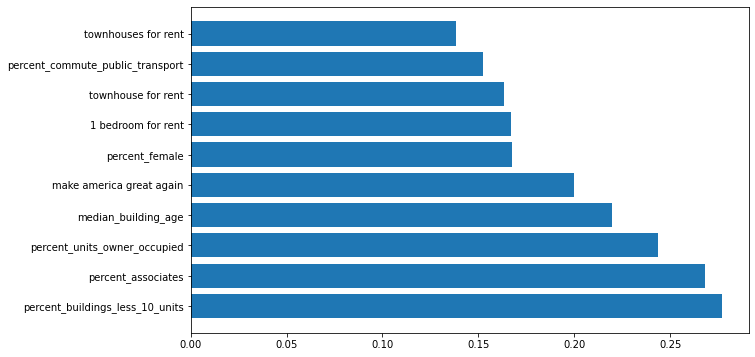


Got an mse at 0.0025 in epoch 40 and stopped training



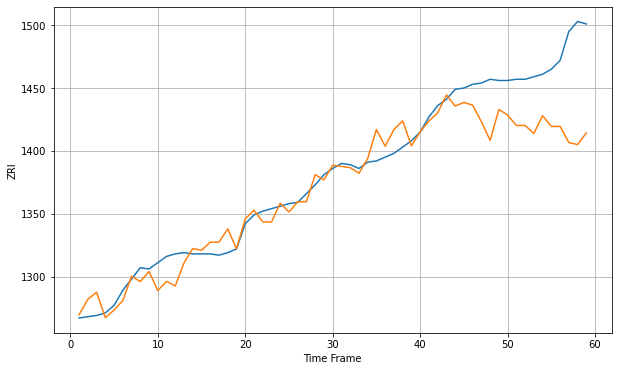

Wall time: 9.03 s
22192 11.738766108062716 57.18847167697329


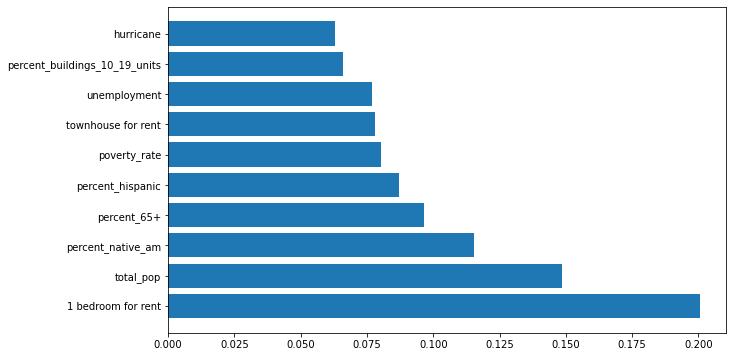


Got an mse at 0.0024 in epoch 60 and stopped training



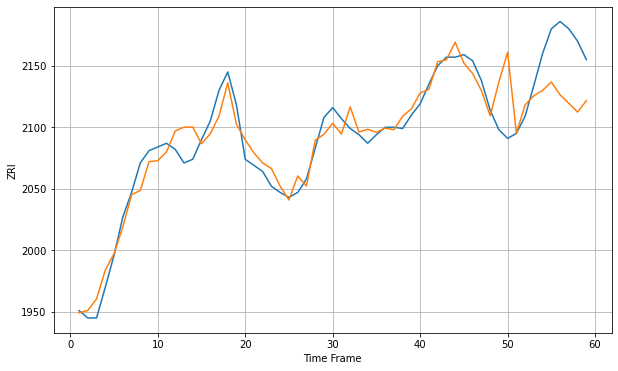

Wall time: 9.84 s
22201 11.66702323475915 41.84544619887348


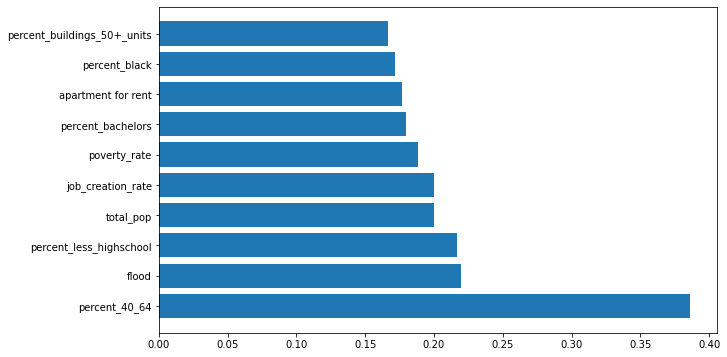


Got an mse at 0.0025 in epoch 42 and stopped training



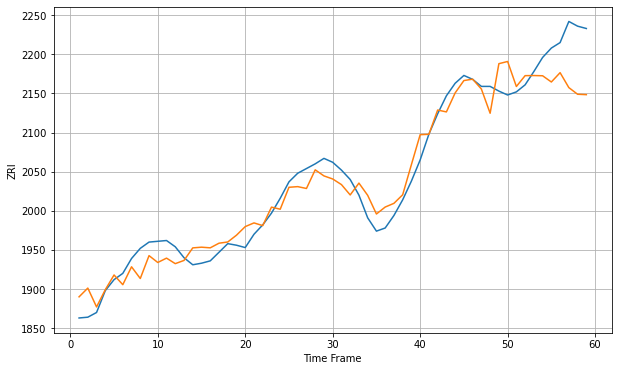

Wall time: 9.01 s
22202 18.509077989031887 50.1967438303102


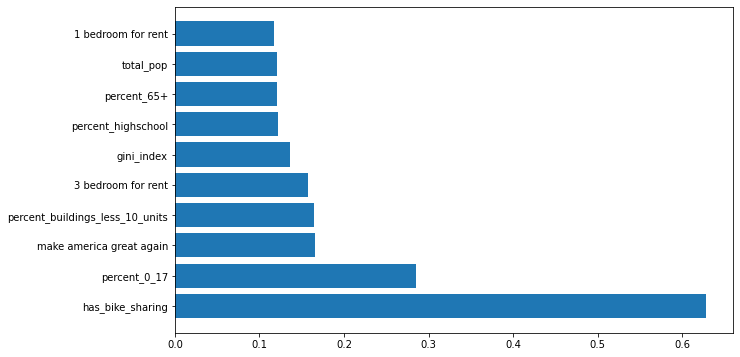


Got an mse at 0.0025 in epoch 37 and stopped training



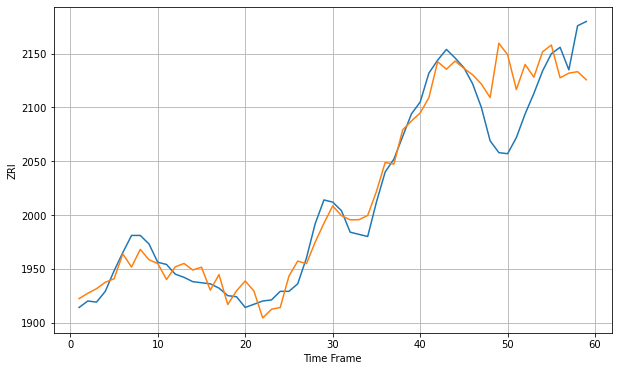

Wall time: 9.67 s
22203 13.010155942822355 50.6184533217438


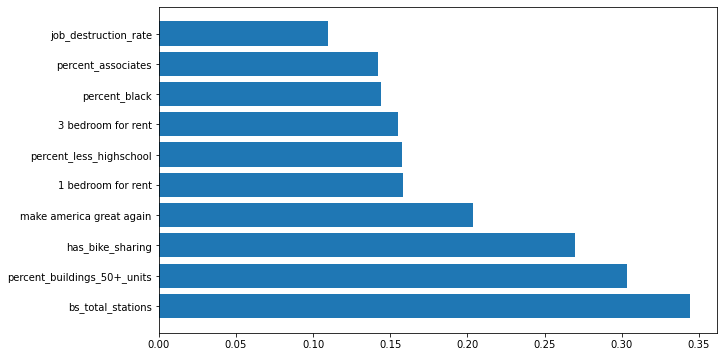


Got an mse at 0.0025 in epoch 26 and stopped training



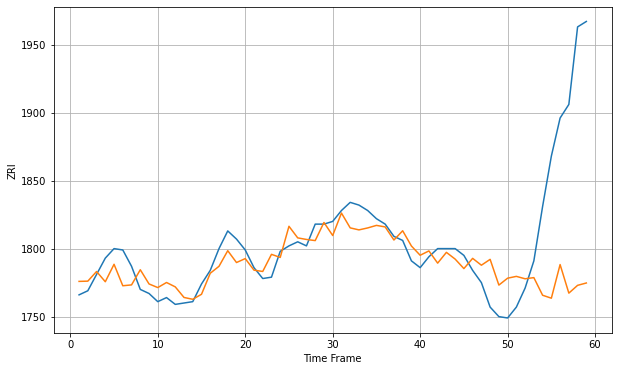

Wall time: 8.87 s
22204 10.739776292204938 101.0087959004807


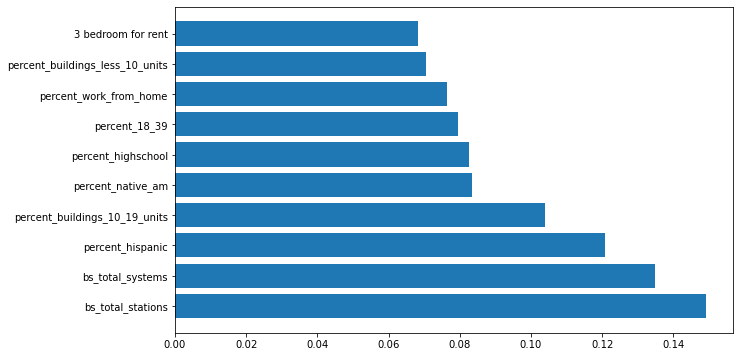


Got an mse at 0.0024 in epoch 55 and stopped training



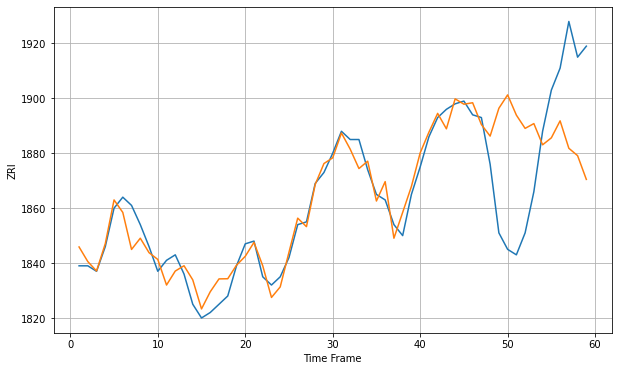

Wall time: 9.88 s
22206 5.239364847517899 37.02761932762551


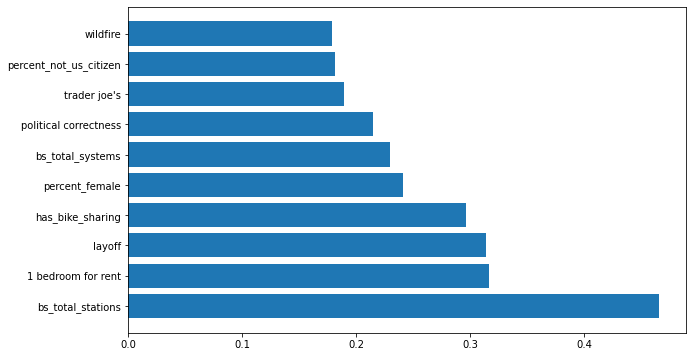


Got an mse at 0.0024 in epoch 128 and stopped training



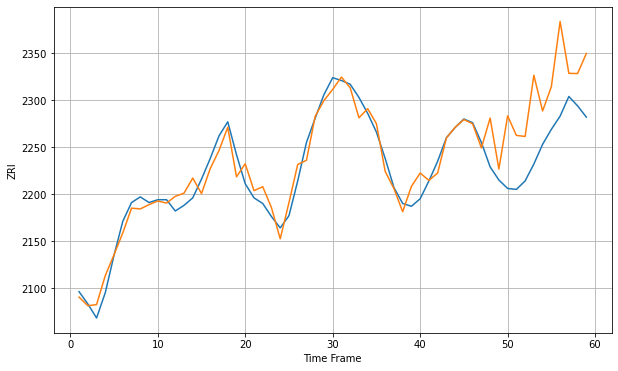

Wall time: 11.5 s
22209 12.527175622500145 60.02881453128339


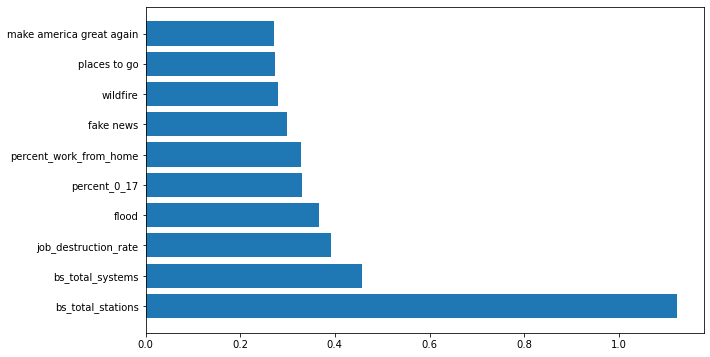


Got an mse at 0.0025 in epoch 194 and stopped training



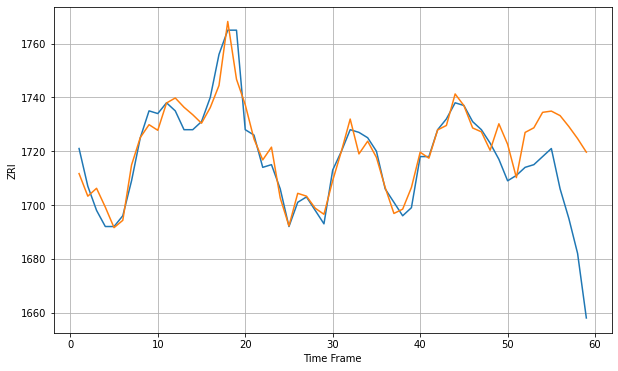

Wall time: 13.5 s
22303 5.299350064566992 26.956044244850276


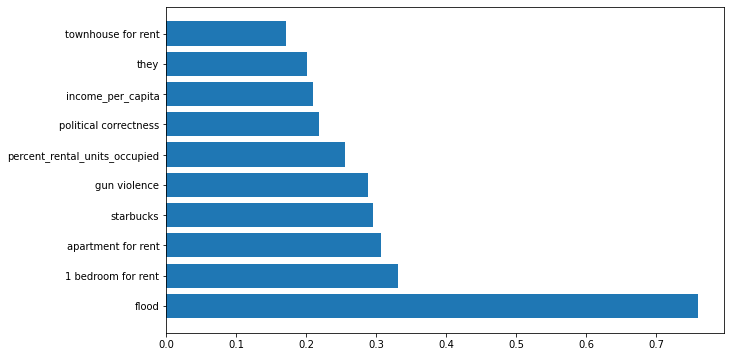


Got an mse at 0.0025 in epoch 120 and stopped training



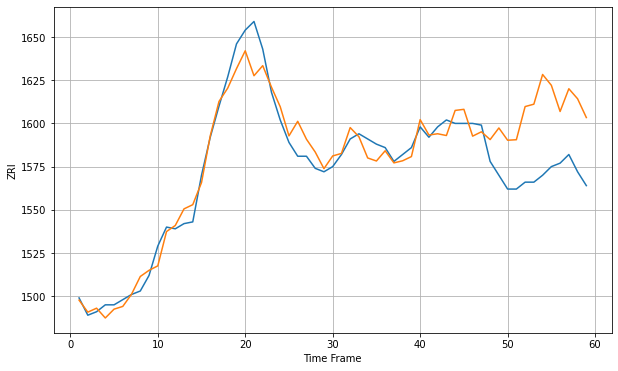

Wall time: 11.2 s
22304 8.393446310617044 38.4794097058307


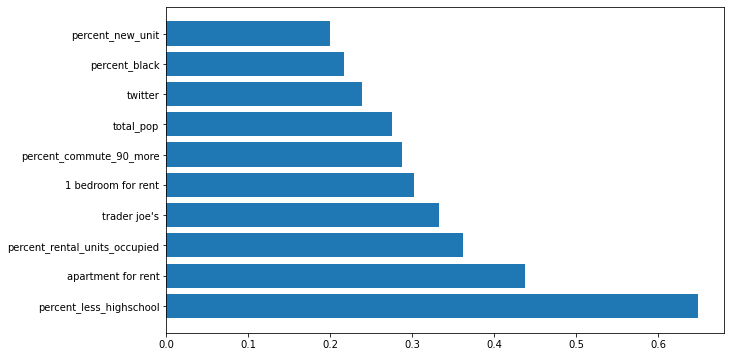


Got an mse at 0.0025 in epoch 93 and stopped training



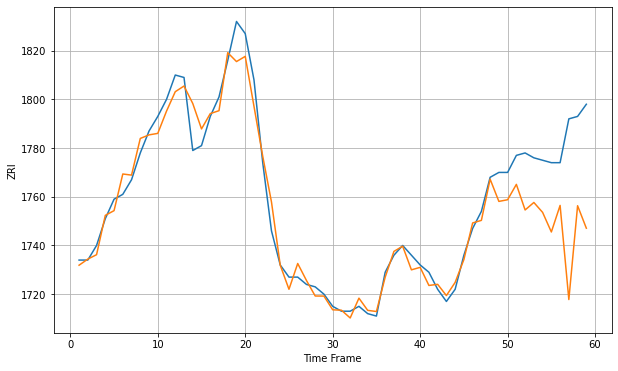

Wall time: 11.2 s
22305 5.808232257285647 32.036581476408976


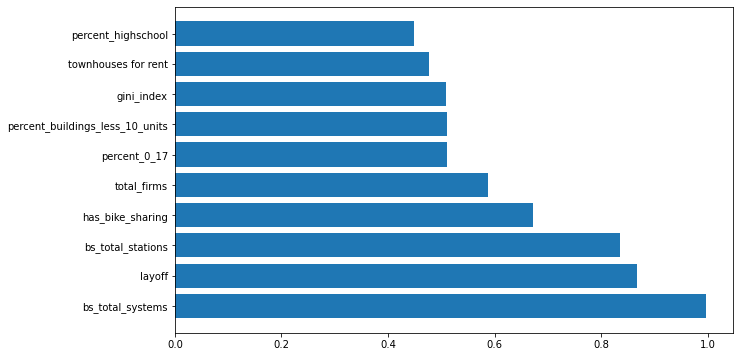


Got an mse at 0.0025 in epoch 70 and stopped training



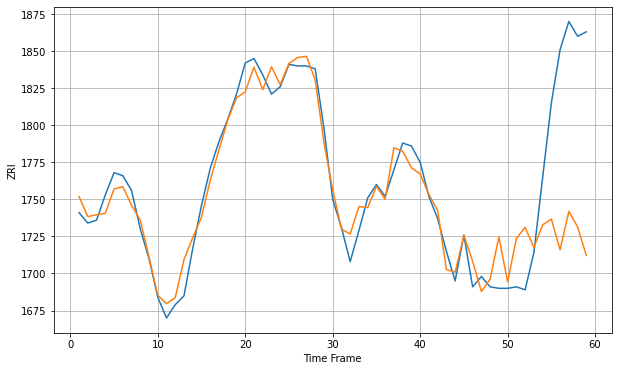

Wall time: 10.3 s
22312 9.761103993387534 84.24412683623595


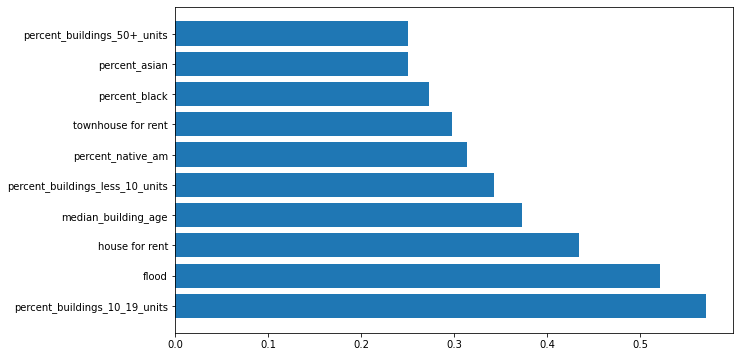


Got an mse at 0.0025 in epoch 38 and stopped training



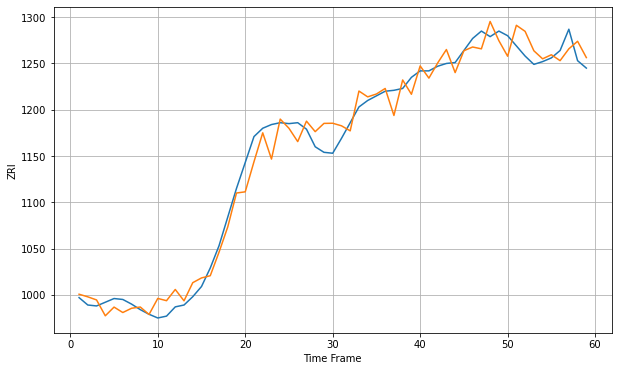

Wall time: 8.96 s
22901 15.272099383367905 16.95852308331124


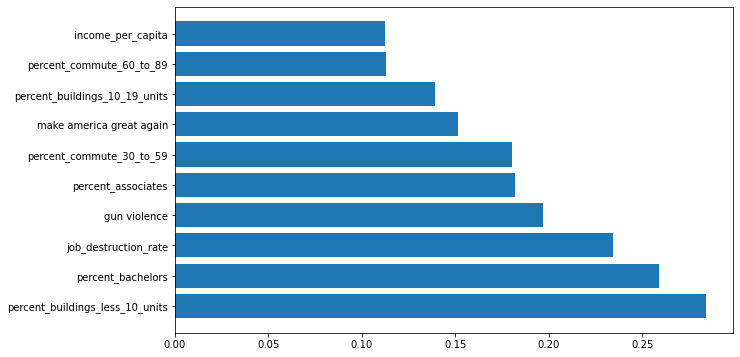


Got an mse at 0.0025 in epoch 48 and stopped training



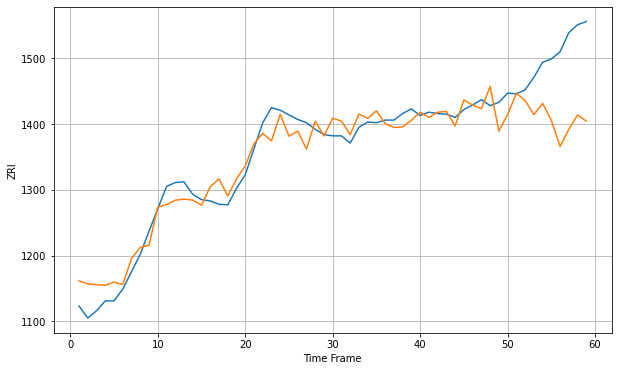

Wall time: 9.26 s
22903 22.007864402387042 93.15327884225061


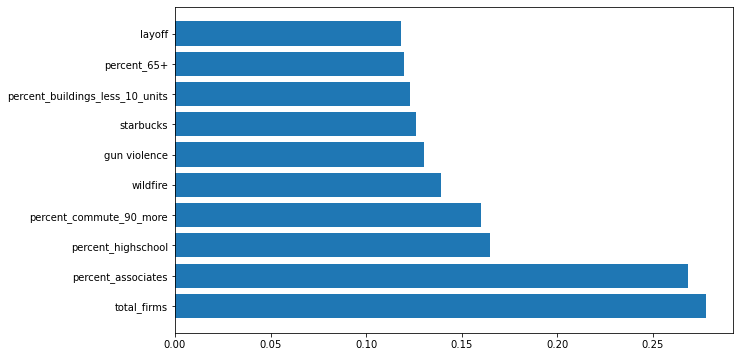


Got an mse at 0.0025 in epoch 101 and stopped training



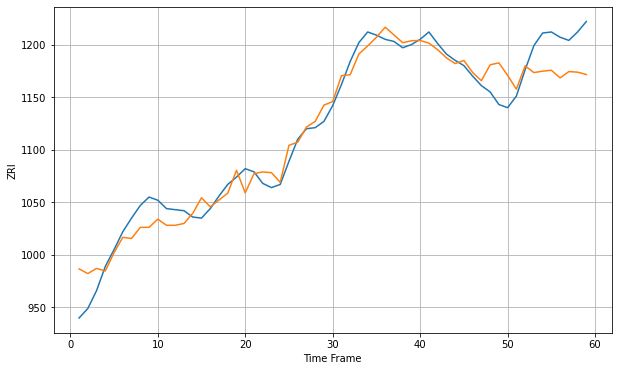

Wall time: 11 s
23220 14.020518078137972 32.811402241275495


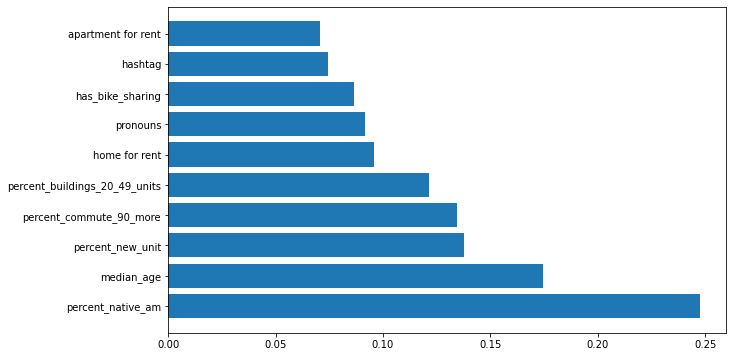


Got an mse at 0.0025 in epoch 97 and stopped training



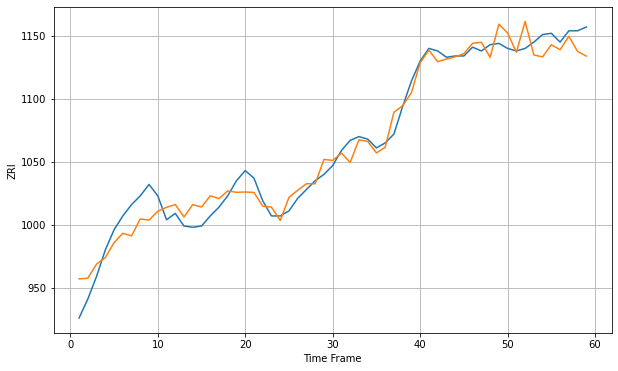

Wall time: 10.6 s
23223 11.6995380426353 13.850845993505255


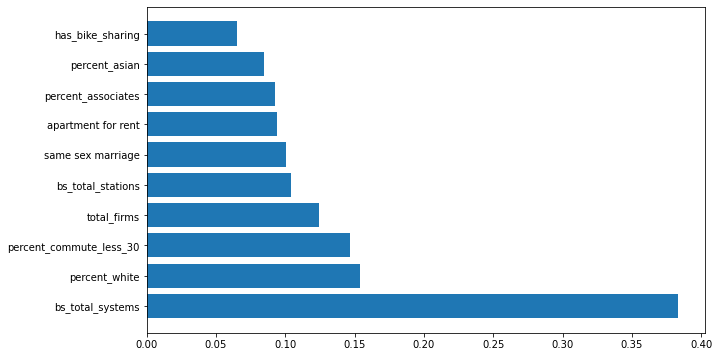


Got an mse at 0.0025 in epoch 54 and stopped training



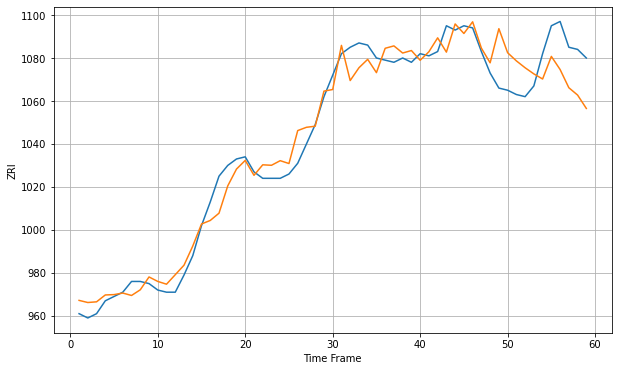

Wall time: 9.46 s
23294 6.798545846722884 17.674116977828987


In [ ]:
score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "importance":[]};
with tf.device('/cpu:0'):
    # for ZONE in zip_ids:
    for ZONE in zip_ids[START_NUM:END_NUM]:
        %time M_train, M_test, model, scaler, series_transformed =\
        NN_test(ZONE, termination=0.0025, plot=True);
        print(ZONE, M_train, M_test);

        score_dict["zip"].append(ZONE);
        score_dict["RMSE_train"].append(M_train);
        score_dict["RMSE_test"].append(M_test);
        
        # Computing the feature importance
        
        results, actual = NN_forecast(model, series_transformed);
        mse = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5;
        perm_importance = [];
        TRIALS = 2;
        PLOT_IMPORTANCE = True;
        
        for i in range(1, len(feature_name)):
            mse_feat = [];
            for _ in range(TRIALS):
                seq_perm = series_transformed.copy();
                seq_perm[:, i] = np.random.permutation(seq_perm[:,i])
                results, actual = NN_forecast(model, seq_perm);
                mse_feat.append(mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5);
                
            perm_importance.append(sum(mse_feat)/TRIALS/mse - 1.0);
        
        importance = pd.DataFrame({"Feature": feature_name[1:], "Importance": perm_importance});
        importance.sort_values("Importance", ascending = False, inplace = True);
        
        plt.figure(figsize=(10, 6));
        plt.barh(importance["Feature"][:10], importance["Importance"][:10]);
        plt.show();
        
        score_dict["importance"].append(perm_importance);

In [ ]:
print(sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]));

In [ ]:
test = pd.DataFrame(score_dict);
test.to_csv('NN_feature_window_1_overoverfit_importance_4.csv', index = False);